In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from scipy import ndimage
import matplotlib.gridspec as gridspec

import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [2]:
CUBE_PATH = "../sdss_cube_sfr/SDSS_cube_lean.h5"
sfrs = pd.read_hdf(CUBE_PATH, key="fits_spectra_metadata_star_formation_rates")
with h5py.File(CUBE_PATH, "r") as cube:
    metadata = cube["dense_cube/0/ml_spectrum/spec_metadata_refs"][:]
metadata_indices = metadata[:, 0]["ds_slice_idx"]

# Data exploration and processing:

In [3]:
sfrs = sfrs[sfrs.index.isin(metadata_indices)].copy()
sfrs = sfrs[sfrs["AVG"].notna()].copy()
sfrs_filtered = sfrs[sfrs["AVG"] >= -80].copy()
sfrs_flag0_filtered = sfrs_filtered[sfrs_filtered["FLAG"] == 0.0].copy()

print("Total records (before filtering):", len(sfrs))
print("Total records (after filtering AVG >= -80):", len(sfrs_filtered))
print("FLAG == 0 count:", len(sfrs_flag0_filtered))

mask_all = np.in1d(metadata_indices, sfrs_filtered.index)
mask_flag0 = np.in1d(metadata_indices, sfrs_flag0_filtered.index)
selected_all = metadata_indices[mask_all]
selected_flag0 = metadata_indices[mask_flag0]

Total records (before filtering): 34613
Total records (after filtering AVG >= -80): 30752
FLAG == 0 count: 16841


In [4]:
all_images = []
all_spectra = []
filtered_images = []
filtered_spectra = []

for zoom in range(4):
    img_key = f"dense_cube/{zoom}/ml_image/cutout_3d_cube_zoom_{zoom}"
    spec_key = f"dense_cube/{zoom}/ml_spectrum/spectral_1d_cube_zoom_{zoom}"
    with h5py.File(CUBE_PATH, "r") as cube:
        images_zoom = cube[img_key][:][mask_all]
        spectra_zoom = cube[spec_key][:][mask_all]
    all_images.append(images_zoom)
    all_spectra.append(spectra_zoom)
    
    with h5py.File(CUBE_PATH, "r") as cube:
        images_zoom_flag0 = cube[img_key][:][mask_flag0]
        spectra_zoom_flag0 = cube[spec_key][:][mask_flag0]
    filtered_images.append(images_zoom_flag0)
    filtered_spectra.append(spectra_zoom_flag0)

print("All images shape (zoom 0):", all_images[0].shape)
print("Filtered images shape (zoom 0):", filtered_images[0].shape)
print("All spectra shape (zoom 0):", all_spectra[0].shape)
print("Filtered spectra shape (zoom 0):", filtered_spectra[0].shape)

All images shape (zoom 0): (30752, 5, 64, 64)
Filtered images shape (zoom 0): (16841, 5, 64, 64)
All spectra shape (zoom 0): (30752, 4620)
Filtered spectra shape (zoom 0): (16841, 4620)


In [5]:
mask_clean_all = ~np.isnan(all_spectra[0]).any(axis=1)
mask_clean_flag0 = ~np.isnan(filtered_spectra[0]).any(axis=1)

cleaned_all_images = [arr[mask_clean_all] for arr in all_images]
cleaned_all_spectra = [arr[mask_clean_all] for arr in all_spectra]
cleaned_filtered_images = [arr[mask_clean_flag0] for arr in filtered_images]
cleaned_filtered_spectra = [arr[mask_clean_flag0] for arr in filtered_spectra]

selected_all_clean = selected_all[mask_clean_all]
selected_flag0_clean = selected_flag0[mask_clean_flag0]

cleaned_sfrs_all = sfrs_filtered.loc[selected_all_clean]
cleaned_sfrs_flag0 = sfrs_flag0_filtered.loc[selected_flag0_clean]

print("Cleaned All spectra shape (zoom 0):", cleaned_all_spectra[0].shape)
print("Cleaned FLAG==0 spectra shape (zoom 0):", cleaned_filtered_spectra[0].shape)

Cleaned All spectra shape (zoom 0): (20157, 4620)
Cleaned FLAG==0 spectra shape (zoom 0): (11179, 4620)


In [6]:
def normalize_images(images_list):
    normalized_list = []
    for img_array in images_list:
        min_val = np.min(img_array, axis=(2,3), keepdims=True)
        max_val = np.max(img_array, axis=(2,3), keepdims=True)
        norm_img = 2 * (img_array - min_val) / (max_val - min_val) - 1
        normalized_list.append(norm_img)
    return normalized_list

normalized_all_images = normalize_images(cleaned_all_images)
normalized_filtered_images = normalize_images(cleaned_filtered_images)

def normalize_spectra(spectra_list):
    normalized_list = []
    for spec in spectra_list:
        if spec.ndim == 1:
            spec = spec[np.newaxis, :]
        min_val = np.nanmin(spec, axis=1, keepdims=True)
        max_val = np.nanmax(spec, axis=1, keepdims=True)
        diff = np.where((max_val - min_val)==0, 1, max_val - min_val)
        norm_spec = 2 * (spec - min_val) / diff - 1
        normalized_list.append(norm_spec)
    return normalized_list

normalized_all_spectra = normalize_spectra(cleaned_all_spectra)
normalized_filtered_spectra = normalize_spectra(cleaned_filtered_spectra)

FLAG == 0 (Original): Found 1111 images with multiple objects from 11179 (9.94%).


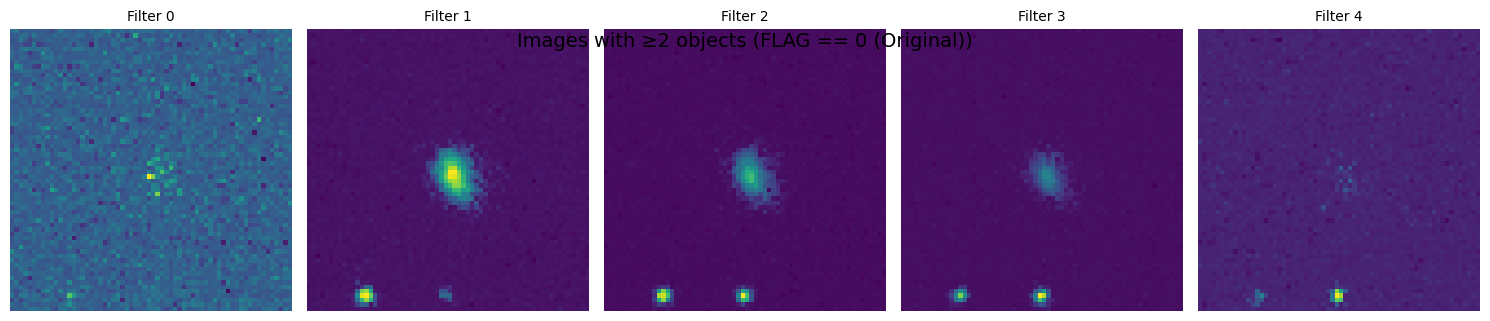

In [7]:
selected_Y_flag0 = cleaned_sfrs_flag0.loc[selected_flag0_clean]["AVG"].values

CROP_SIZES_4 = {0: 32, 1: 16, 2: 8, 3: 4} 
THRESHOLD = 0.9

def detect_and_visualize_multiple_objects(images_list, thresholds, crop_sizes=None, max_objects=1, thumbnail_size=3, group_name="", print_spectra=False, spectra_list=None):
    images_trimmed = []
    for i, img_array in enumerate(images_list):
        original_size = img_array.shape[-1]
        target_size = crop_sizes.get(i, original_size) if crop_sizes is not None else original_size
        start = (original_size - target_size) // 2
        end = start + target_size
        trimmed = img_array[..., start:end, start:end]
        images_trimmed.append(trimmed)
    multi_obj_indices = []
    for idx in range(images_trimmed[0].shape[0]):
        image = images_trimmed[0][idx, 2, :, :]
        image_normalized = (image + 1) / 2
        binary = image_normalized > thresholds
        labeled, num_features = ndimage.label(binary)
        if num_features > 1:
            multi_obj_indices.append(idx)
    total_images = images_trimmed[0].shape[0]
    count_multi = len(multi_obj_indices)
    percent_multi = (count_multi / total_images)*100 if total_images>0 else 0
    print(f"{group_name}: Found {count_multi} images with multiple objects from {total_images} ({percent_multi:.2f}%).")
    if multi_obj_indices:
        display_indices = multi_obj_indices[:max_objects]
        if print_spectra and spectra_list is not None:
            num_disp = len(display_indices)
            fig = plt.figure(figsize=(15, thumbnail_size * 2 * num_disp), dpi=100)
            gs = gridspec.GridSpec(2 * num_disp, 5, hspace=0.6, wspace=0.3)
            for i, obj_idx in enumerate(display_indices):
                for col in range(5):
                    ax = fig.add_subplot(gs[2*i, col])
                    img_data = images_trimmed[0][obj_idx, col, :, :]
                    ax.imshow(img_data, vmin=-1, vmax=1)
                    ax.set_title(f"Filter {col}", fontsize=10)
                    ax.axis("off")
                ax_spec = fig.add_subplot(gs[2*i+1, :])
                spectrum = spectra_list[0][obj_idx]
                wavelengths = np.linspace(3800,9200, len(spectrum))
                ax_spec.plot(wavelengths, spectrum, linewidth=0.3)
                ax_spec.set_title("Spectrum (Zoom 0)", fontsize=10)
                ax_spec.set_xlabel("Wavelength (Å)", fontsize=10)
                ax_spec.set_ylabel("Flux", fontsize=10)
                ax_spec.set_xlim([3800,9200])
                ax_spec.set_ylim([-1,1])
            fig.suptitle(f"Images with ≥2 objects and spectra ({group_name})", fontsize=14)
            fig.tight_layout()
            fig.subplots_adjust(top=0.93)
            plt.show()
        else:
            num_disp = len(display_indices)
            fig, axes = plt.subplots(num_disp, 5, figsize=(15, thumbnail_size * num_disp), dpi=100)
            if num_disp == 1:
                axes = axes.reshape(1, -1)
            for row, obj_idx in enumerate(display_indices):
                for col in range(5):
                    ax = axes[row, col]
                    img_data = images_trimmed[0][obj_idx, col, :, :]
                    ax.imshow(img_data, vmin=-1, vmax=1)
                    ax.set_title(f"Filter {col}", fontsize=10)
                    ax.axis("off")
            fig.suptitle(f"Images with ≥2 objects ({group_name})", fontsize=14)
            fig.tight_layout()
            fig.subplots_adjust(top=0.99)
            plt.show()
    else:
        print(f"No images found for {group_name} with multiple objects.")
    return images_trimmed, multi_obj_indices

orig_images_flag0, multi_obj_indices_flag0 = detect_and_visualize_multiple_objects(
    normalized_filtered_images, thresholds=THRESHOLD, crop_sizes=None,
    group_name="FLAG == 0 (Original)", print_spectra=False, spectra_list=normalized_filtered_spectra
)

In [8]:
X_photo_all = orig_images_flag0[0]        
X_spec_all = normalized_filtered_spectra[0]  
mask_good = np.ones(X_photo_all.shape[0], dtype=bool)
mask_good[multi_obj_indices_flag0] = False

X_photo = X_photo_all[mask_good]
X_spec = X_spec_all[mask_good]
Y = selected_Y_flag0[:X_photo_all.shape[0]][mask_good]

n_samples = min(X_photo.shape[0], X_spec.shape[0], len(Y))
X_photo = X_photo[:n_samples]
X_spec = X_spec[:n_samples]
Y = Y[:n_samples]

In [9]:
X_photo_train_val, X_photo_test, X_spec_train_val, X_spec_test, Y_train_val, Y_test = train_test_split(
    X_photo, X_spec, Y, test_size=0.2, random_state=42
)
X_photo_train, X_photo_val, X_spec_train, X_spec_val, Y_train, Y_val = train_test_split(
    X_photo_train_val, X_spec_train_val, Y_train_val, test_size=0.25, random_state=42
)

print("Train samples:", X_photo_train.shape[0])
print("Validation samples:", X_photo_val.shape[0])
print("Test samples:", X_photo_test.shape[0])

Train samples: 6040
Validation samples: 2014
Test samples: 2014


# Machine Learning (FLAG == 0 only):

## VGGNet12:

In [10]:
class CustomMSELoss(nn.Module):
    def __init__(self):
        super(CustomMSELoss, self).__init__()
    def forward(self, output, target):
        if target.dim() == 1:
            target = target.view(-1, 1)
        return F.mse_loss(output, target)

class VGGNet12(nn.Module):
    def __init__(self, input_channels, input_height, input_width, dropout=0.5):
        super(VGGNet12, self).__init__()
        if input_height == 1:
            pool1 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
            pool2 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        else:
            pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            pool1
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            pool2
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        pool_h = max(1, input_height // 8)
        pool_w = max(1, input_width // 8)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((pool_h, pool_w))
        fc_input_dim = 256 * pool_h * pool_w
        self.fc1 = nn.Linear(fc_input_dim, 512)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(128, 1)
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [11]:
def plot_history(net, title, q):
    train_losses = net.history[:, 'train_loss']
    valid_losses = net.history[:, 'valid_loss']
    best_epoch = np.argmin(valid_losses)
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Valid Loss')
    plt.axvline(x=best_epoch, color='red', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title} Quality {q} - Training & Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def run_skorch_grid_search_vgg(X_train, Y_train, X_val, Y_val, param_grid,
                               in_ch, in_h, in_w, title, q):
    results = {'lr': [], 'r2': [], 'mae': [], 'nmad': [], 'rmse': []}
    best_net = None
    best_score = -np.inf
    best_params = None

    for lr in param_grid['lr']:
        net = NeuralNetRegressor(
            module=VGGNet12,
            module__input_channels=in_ch,
            module__input_height=in_h,
            module__input_width=in_w,
            module__dropout=param_grid['module__dropout'][0],
            max_epochs=100,
            lr=lr,
            optimizer=torch.optim.Adam,
            batch_size=32,
            iterator_train__shuffle=True,
            callbacks=[EarlyStopping(patience=param_grid['callbacks__early_stopping__patience'][0])],
            device='cuda' if torch.cuda.is_available() else 'cpu',
            criterion=CustomMSELoss,
        )
        net.fit(X_train, Y_train)
        plot_history(net, title, q)

        Y_pred = net.predict(X_val)
        mae = mean_absolute_error(Y_val, Y_pred)
        r2 = r2_score(Y_val, Y_pred)
        error = Y_pred - Y_val
        nmad = 1.4826 * np.median(np.abs(error - np.median(error)))
        rmse = np.sqrt(mean_squared_error(Y_val, Y_pred))

        results['lr'].append(lr)
        results['r2'].append(r2)
        results['mae'].append(mae)
        results['nmad'].append(nmad)
        results['rmse'].append(rmse)

        if r2 > best_score:
            best_score = r2
            best_net = net
            best_params = {'lr': lr, 'dropout': param_grid['module__dropout'][0]}

    print(f"{title} Quality {q} best params: {best_params}")
    return best_net, best_params, results

def visualize_lr_results(res, title, q):
    lrs = res['lr']
    plt.figure(figsize=(14, 10))
    metrics = ['r2','rmse','mae','nmad']
    for i, m in enumerate(metrics,1):
        plt.subplot(2,2,i)
        plt.plot(lrs, res[m], marker='o')
        plt.xscale('log')
        plt.title(f'{title} Quality {q} - {m.upper()} vs LR')
        plt.xlabel('Learning Rate (log)')
        plt.ylabel(m.upper())
    plt.tight_layout()
    plt.show()

param_grid_vgg = {
    'lr': [0.00001, 0.000003, 0.000001, 0.0000003],
    'module__dropout': [0.5],
    'callbacks__early_stopping__patience': [10]
}

runtime = {}
best_models_photo = {}
best_models_spec = {}

## Spectrum and Photo separately:

### VGGNet12 on Photo: 


=== VGGNet12 Photo Quality 0 ===
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5415        0.5241  3.6937
      2        0.5343        0.5240  2.5294
      3        0.5336        0.5230  2.5324
      4        0.5319        0.5230  2.5285
      5        0.5305        0.5199  2.5279
      6        0.5296        0.5211  2.5333
      7        0.5287        0.5165  2.5110
      8        0.5269        0.5140  2.5174
      9        0.5260        0.5106  2.5260
     10        0.5216        0.5083  2.5164
     11        0.5164        0.5042  2.5121
     12        0.5047        0.4791  2.5130
     13        0.4941        0.4655  2.5134
     14        0.4832        0.4580  2.5134
     15        0.4768        0.4489  2.5116
     16        0.4711        0.4915  2.5128
     17        0.4670        0.4384  2.5136
     18        0.4699        0.4403  2.5147
     19        0.4591        0.4236  2.5157
     20        0.4560        0.4330  2.516

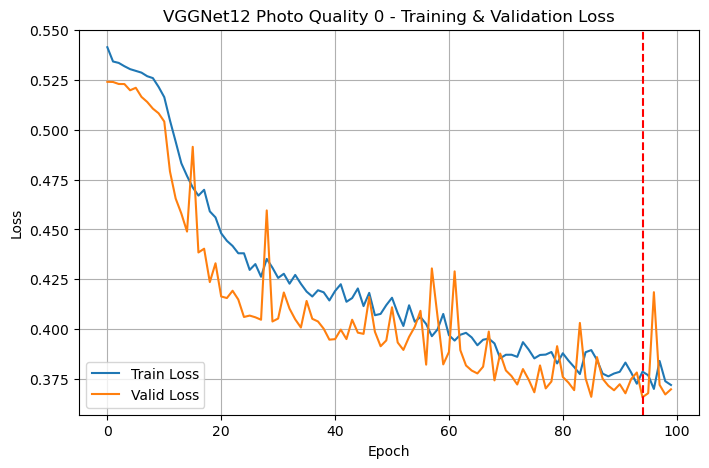

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5467        0.5365  2.5157
      2        0.5362        0.5245  2.5161
      3        0.5351        0.5243  2.5248
      4        0.5336        0.5246  2.5180
      5        0.5341        0.5244  2.5134
      6        0.5345        0.5246  2.5155
      7        0.5336        0.5245  2.5318
      8        0.5336        0.5241  2.5341
      9        0.5326        0.5232  2.5346
     10        0.5318        0.5227  2.5335
     11        0.5317        0.5229  2.5336
     12        0.5300        0.5228  2.5365
     13        0.5298        0.5227  2.5332
     14        0.5285        0.5211  2.5295
     15        0.5273        0.5214  2.5252
     16        0.5279        0.5222  2.5301
     17        0.5261        0.5186  2.5264
     18        0.5266        0.5191  2.5307
     19        0.5262        0.5207  2.5264
     20        0.5255        0.5162  2.5260
     21        0.5240        0.5

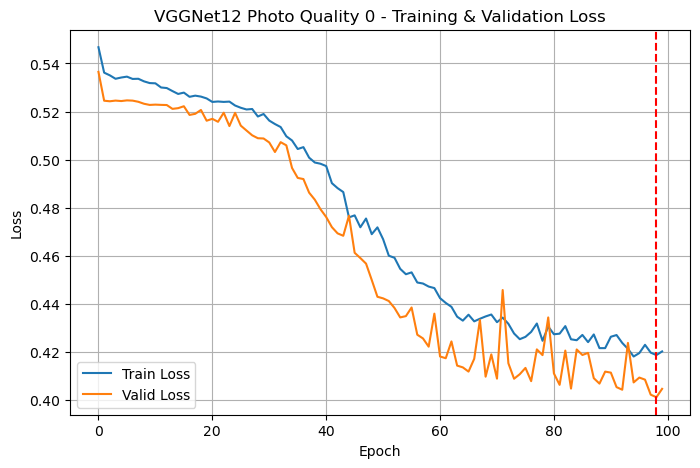

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5539        0.5478  2.5194
      2        0.5500        0.5439  2.5123
      3        0.5468        0.5385  2.5183
      4        0.5419        0.5321  2.5148
      5        0.5360        0.5266  2.5180
      6        0.5371        0.5254  2.5137
      7        0.5349        0.5251  2.5207
      8        0.5342        0.5247  2.5154
      9        0.5348        0.5245  2.5202
     10        0.5326        0.5244  2.5188
     11        0.5338        0.5245  2.5208
     12        0.5351        0.5246  2.5142
     13        0.5336        0.5245  2.5217
     14        0.5334        0.5245  2.5174
     15        0.5344        0.5243  2.5212
     16        0.5335        0.5244  2.5157
     17        0.5335        0.5244  2.5187
     18        0.5346        0.5244  2.5170
     19        0.5329        0.5242  2.5239
     20        0.5340        0.5242  2.5156
     21        0.5334        0.5

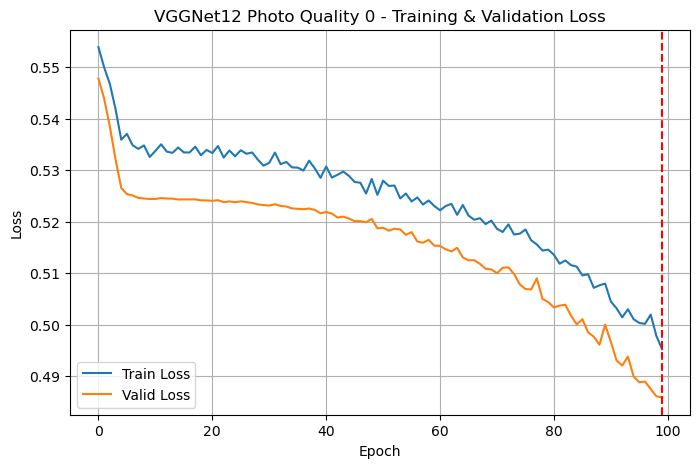

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5526        0.5481  2.5142
      2        0.5516        0.5470  2.5168
      3        0.5506        0.5458  2.5125
      4        0.5495        0.5447  2.5137
      5        0.5486        0.5436  2.5144
      6        0.5474        0.5426  2.5144
      7        0.5463        0.5413  2.5154
      8        0.5454        0.5399  2.5153
      9        0.5444        0.5385  2.5148
     10        0.5439        0.5373  2.5162
     11        0.5418        0.5358  2.5145
     12        0.5411        0.5343  2.5153
     13        0.5398        0.5327  2.5147
     14        0.5386        0.5311  2.5164
     15        0.5370        0.5296  2.5156
     16        0.5358        0.5281  2.5149
     17        0.5352        0.5272  2.5158
     18        0.5350        0.5264  2.5163
     19        0.5342        0.5258  2.5147
     20        0.5346        0.5254  2.5135
     21        0.5356        0.5

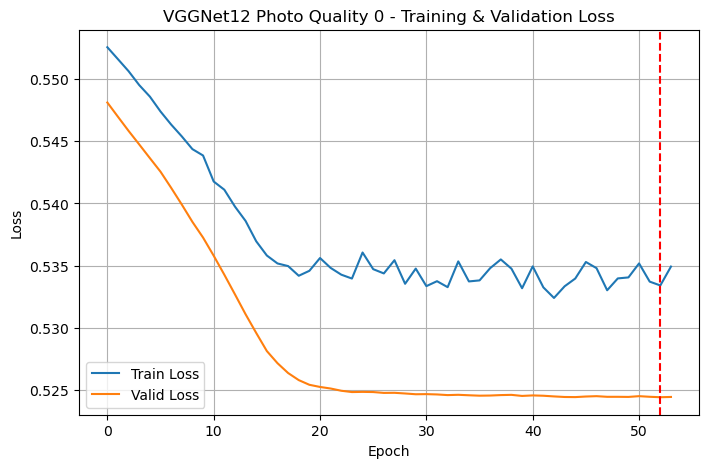

VGGNet12 Photo Quality 0 best params: {'lr': 1e-05, 'dropout': 0.5}


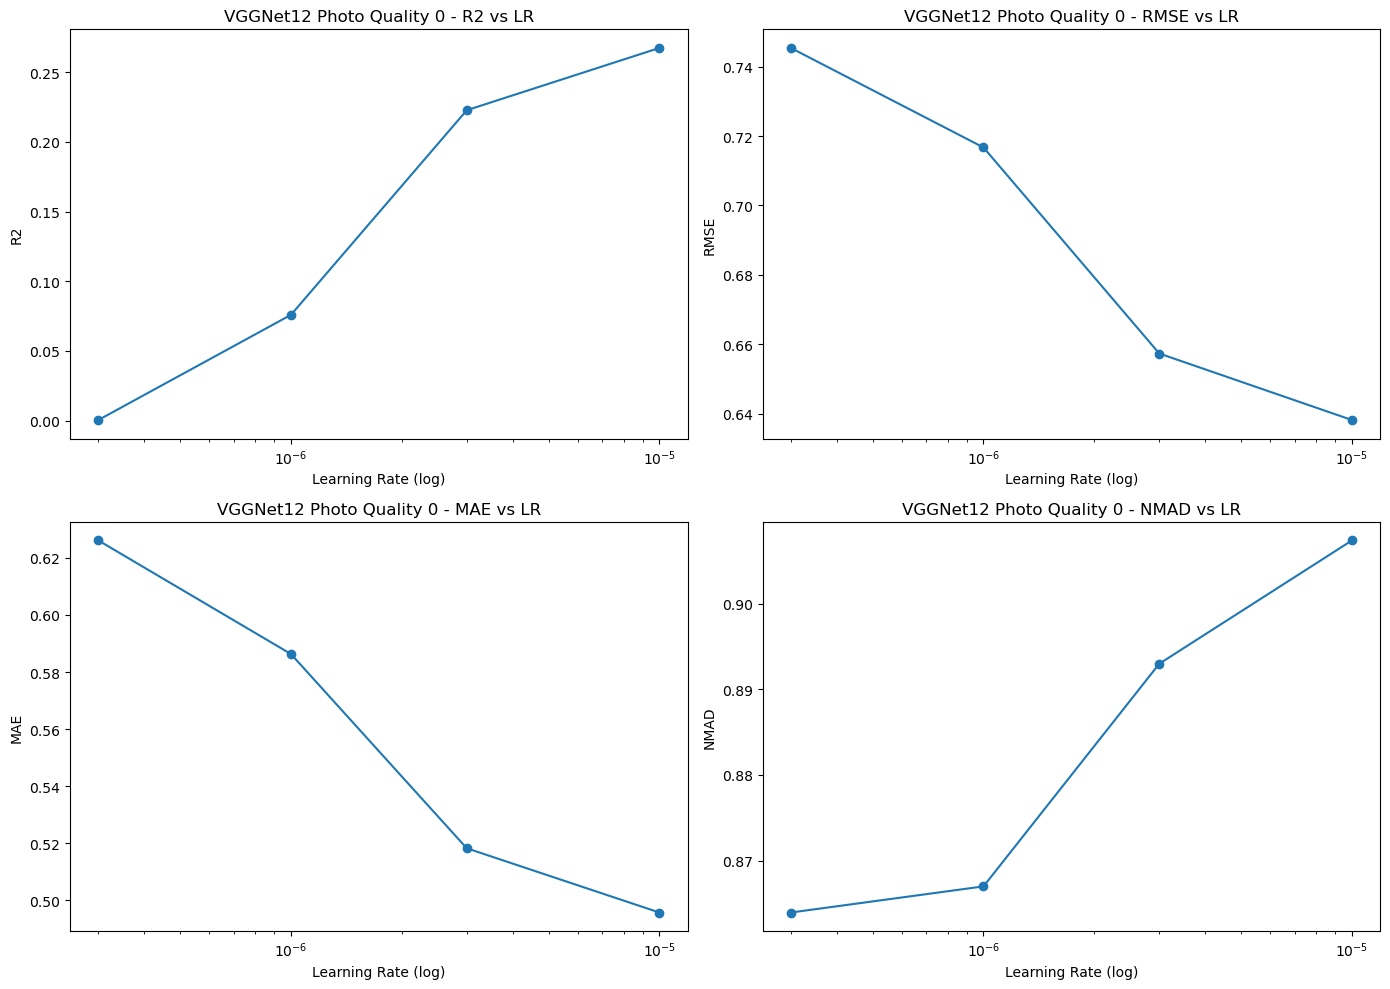


=== VGGNet12 Photo Quality 1 ===
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5473        0.5249  1.2225
      2        0.5357        0.5241  1.0976
      3        0.5353        0.5239  1.0964
      4        0.5326        0.5234  1.0966
      5        0.5332        0.5236  1.0962
      6        0.5312        0.5221  1.1012
      7        0.5319        0.5224  1.0996
      8        0.5302        0.5215  1.1002
      9        0.5309        0.5209  1.0989
     10        0.5296        0.5206  1.0994
     11        0.5288        0.5172  1.0975
     12        0.5272        0.5166  1.0980
     13        0.5264        0.5143  1.0996
     14        0.5249        0.5142  1.0981
     15        0.5221        0.5069  1.0904
     16        0.5122        0.4917  1.0839
     17        0.4973        0.4750  1.0813
     18        0.4889        0.4882  1.0808
     19        0.4881        0.4692  1.0821
     20        0.4833        0.4729  1.082

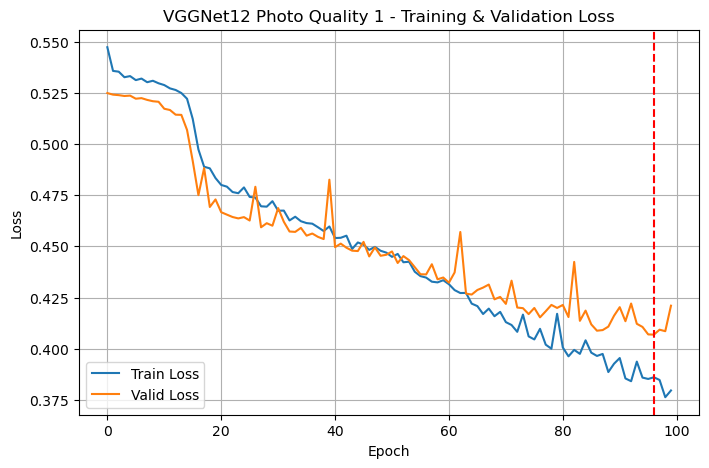

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5933        0.5838  1.0802
      2        0.5625        0.5239  1.0828
      3        0.5360        0.5238  1.0796
      4        0.5374        0.5236  1.0784
      5        0.5381        0.5238  1.0799
      6        0.5353        0.5230  1.0823
      7        0.5359        0.5234  1.0953
      8        0.5355        0.5228  1.0967
      9        0.5387        0.5246  1.0973
     10        0.5344        0.5232  1.0960
     11        0.5347        0.5227  1.0961
     12        0.5346        0.5235  1.0960
     13        0.5334        0.5227  1.0953
     14        0.5345        0.5222  1.0943
     15        0.5343        0.5227  1.0956
     16        0.5347        0.5215  1.0977
     17        0.5350        0.5220  1.0956
     18        0.5343        0.5213  1.0972
     19        0.5337        0.5217  1.0958
     20        0.5328        0.5210  1.0958
     21        0.5331        0.5

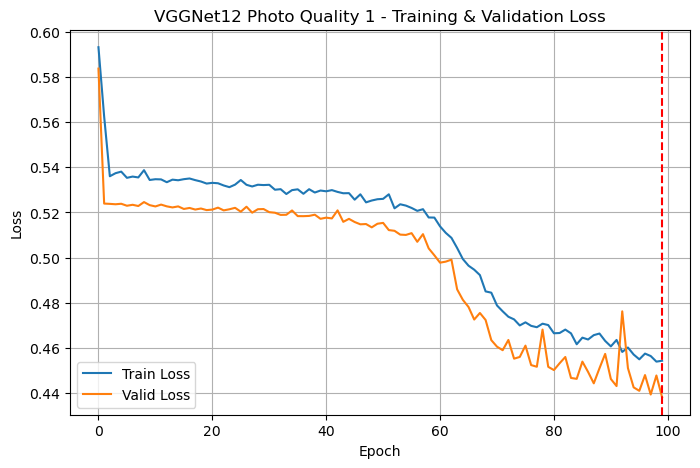

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5636        0.5597  1.0944
      2        0.5617        0.5576  1.0941
      3        0.5598        0.5548  1.0957
      4        0.5566        0.5494  1.0937
      5        0.5492        0.5355  1.0949
      6        0.5377        0.5254  1.0942
      7        0.5334        0.5242  1.0821
      8        0.5352        0.5244  1.0830
      9        0.5356        0.5243  1.0840
     10        0.5348        0.5242  1.0848
     11        0.5346        0.5244  1.0839
     12        0.5356        0.5244  1.0835
     13        0.5362        0.5245  1.0822
     14        0.5335        0.5244  1.0833
     15        0.5342        0.5241  1.0831
     16        0.5343        0.5241  1.0855
     17        0.5341        0.5240  1.0832
     18        0.5327        0.5238  1.0825
     19        0.5345        0.5241  1.0823
     20        0.5348        0.5241  1.0830
     21        0.5353        0.5

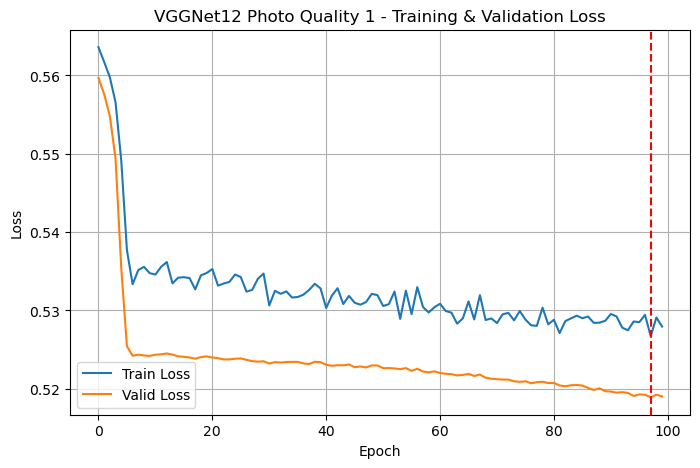

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5455        0.5405  1.0966
      2        0.5452        0.5402  1.0960
      3        0.5450        0.5399  1.0955
      4        0.5450        0.5396  1.0957
      5        0.5441        0.5393  1.0965
      6        0.5443        0.5390  1.0957
      7        0.5441        0.5388  1.0961
      8        0.5437        0.5385  1.0958
      9        0.5436        0.5382  1.0961
     10        0.5433        0.5379  1.0972
     11        0.5433        0.5375  1.0974
     12        0.5428        0.5372  1.0967
     13        0.5418        0.5368  1.0955
     14        0.5422        0.5365  1.0976
     15        0.5417        0.5361  1.0962
     16        0.5415        0.5357  1.1003
     17        0.5409        0.5352  1.0970
     18        0.5407        0.5348  1.0991
     19        0.5405        0.5342  1.0955
     20        0.5400        0.5336  1.0964
     21        0.5391        0.5

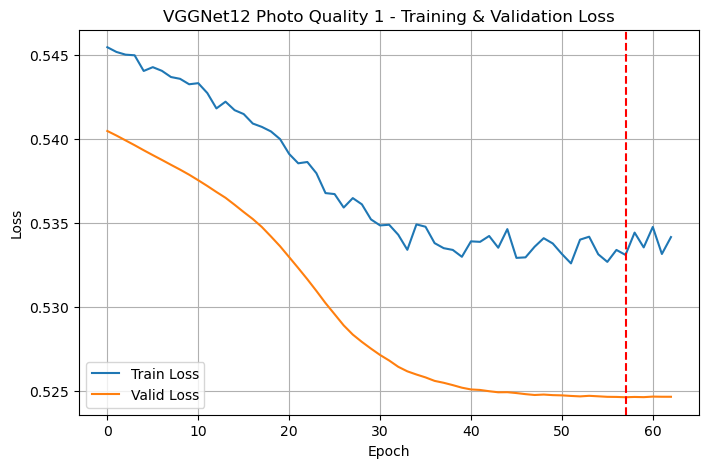

VGGNet12 Photo Quality 1 best params: {'lr': 1e-05, 'dropout': 0.5}


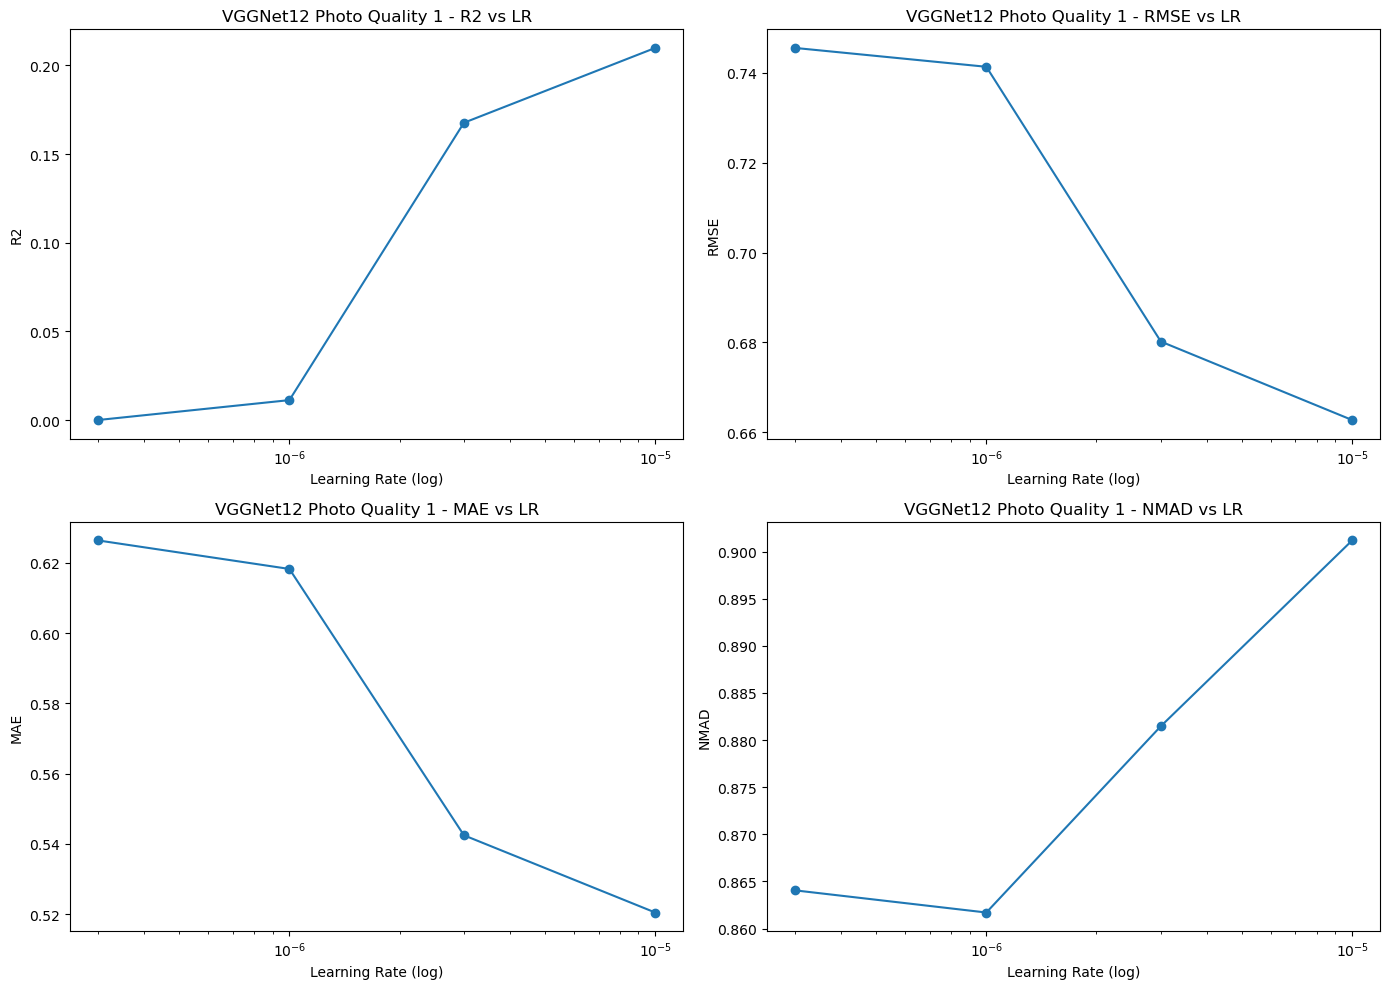


=== VGGNet12 Photo Quality 2 ===
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5431        0.5285  0.6777
      2        0.5347        0.5244  0.6502
      3        0.5340        0.5255  0.6493
      4        0.5358        0.5244  0.6483
      5        0.5330        0.5237  0.6495
      6        0.5333        0.5236  0.6514
      7        0.5326        0.5226  0.6538
      8        0.5316        0.5226  0.6539
      9        0.5303        0.5219  0.6532
     10        0.5290        0.5215  0.6473
     11        0.5289        0.5211  0.6380
     12        0.5275        0.5214  0.6373
     13        0.5277        0.5206  0.6373
     14        0.5265        0.5191  0.6387
     15        0.5270        0.5192  0.6386
     16        0.5278        0.5188  0.6423
     17        0.5266        0.5187  0.6404
     18        0.5262        0.5169  0.6380
     19        0.5267        0.5176  0.6382
     20        0.5247        0.5157  0.638

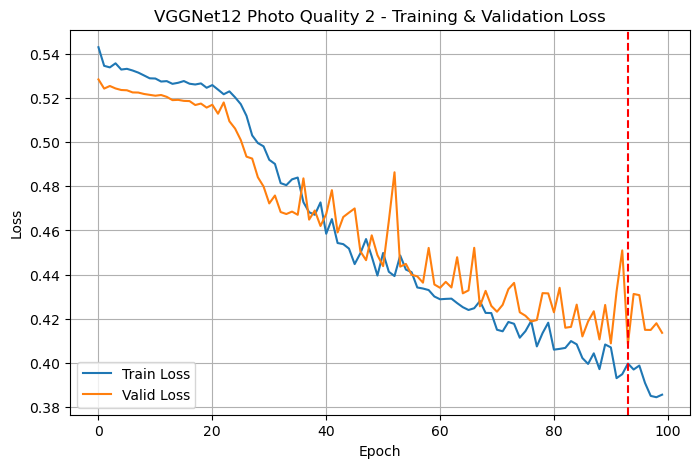

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5561        0.5506  0.6471
      2        0.5530        0.5456  0.6478
      3        0.5424        0.5259  0.6451
      4        0.5339        0.5247  0.6460
      5        0.5350        0.5251  0.6451
      6        0.5361        0.5244  0.6461
      7        0.5355        0.5245  0.6481
      8        0.5328        0.5242  0.6479
      9        0.5354        0.5246  0.6486
     10        0.5358        0.5240  0.6478
     11        0.5349        0.5245  0.6524
     12        0.5333        0.5240  0.6559
     13        0.5336        0.5247  0.6555
     14        0.5337        0.5236  0.6543
     15        0.5340        0.5234  0.6540
     16        0.5317        0.5234  0.6544
     17        0.5320        0.5230  0.6547
     18        0.5332        0.5225  0.6538
     19        0.5325        0.5227  0.6544
     20        0.5319        0.5225  0.6560
     21        0.5308        0.5

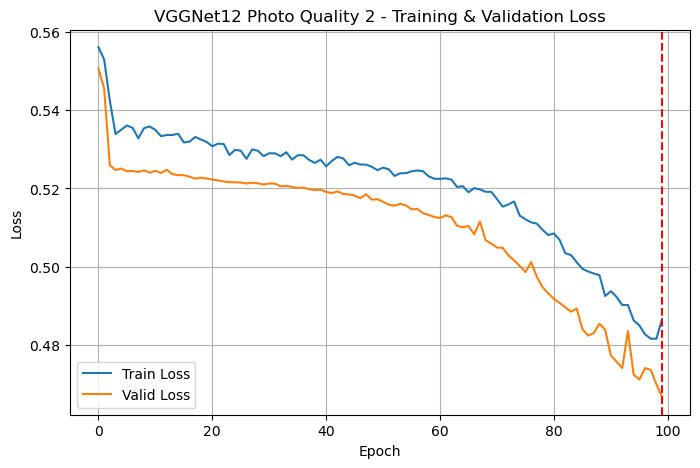

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5650        0.5616  0.6521
      2        0.5638        0.5602  0.6505
      3        0.5629        0.5587  0.6503
      4        0.5613        0.5566  0.6493
      5        0.5581        0.5517  0.6480
      6        0.5518        0.5410  0.6498
      7        0.5419        0.5295  0.6504
      8        0.5351        0.5251  0.6526
      9        0.5347        0.5246  0.6524
     10        0.5343        0.5246  0.6541
     11        0.5364        0.5246  0.6539
     12        0.5343        0.5244  0.6541
     13        0.5343        0.5244  0.6541
     14        0.5334        0.5244  0.6544
     15        0.5337        0.5242  0.6538
     16        0.5342        0.5243  0.6574
     17        0.5345        0.5243  0.6537
     18        0.5338        0.5241  0.6527
     19        0.5340        0.5243  0.6533
     20        0.5340        0.5243  0.6534
     21        0.5346        0.5

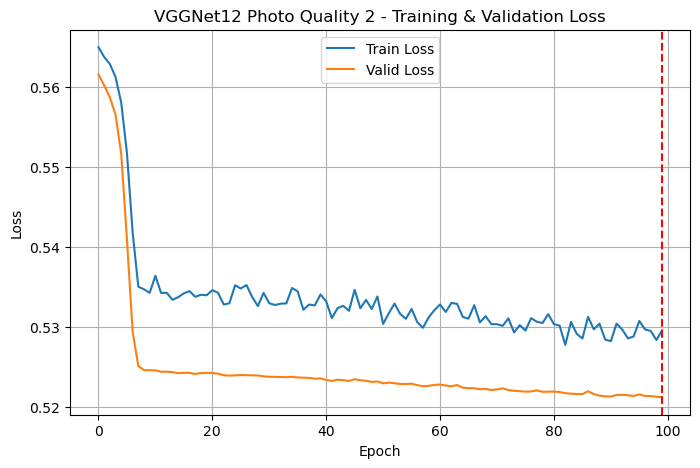

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5422        0.5368  0.6612
      2        0.5424        0.5366  0.6596
      3        0.5417        0.5365  0.6595
      4        0.5421        0.5364  0.6628
      5        0.5421        0.5362  0.6585
      6        0.5412        0.5361  0.6587
      7        0.5414        0.5360  0.6701
      8        0.5414        0.5358  0.6594
      9        0.5407        0.5357  0.6623
     10        0.5414        0.5356  0.6601
     11        0.5410        0.5354  0.6586
     12        0.5407        0.5353  0.6585
     13        0.5408        0.5351  0.6579
     14        0.5402        0.5350  0.6594
     15        0.5406        0.5349  0.6587
     16        0.5406        0.5347  0.6582
     17        0.5403        0.5345  0.6595
     18        0.5397        0.5344  0.6607
     19        0.5397        0.5342  0.6611
     20        0.5400        0.5340  0.6589
     21        0.5399        0.5

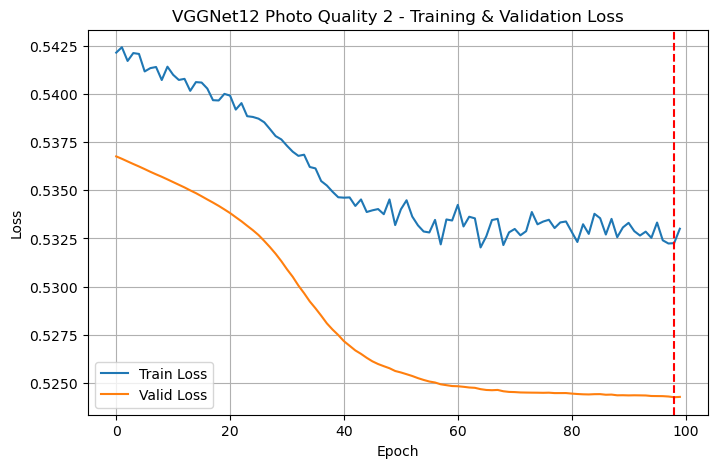

VGGNet12 Photo Quality 2 best params: {'lr': 1e-05, 'dropout': 0.5}


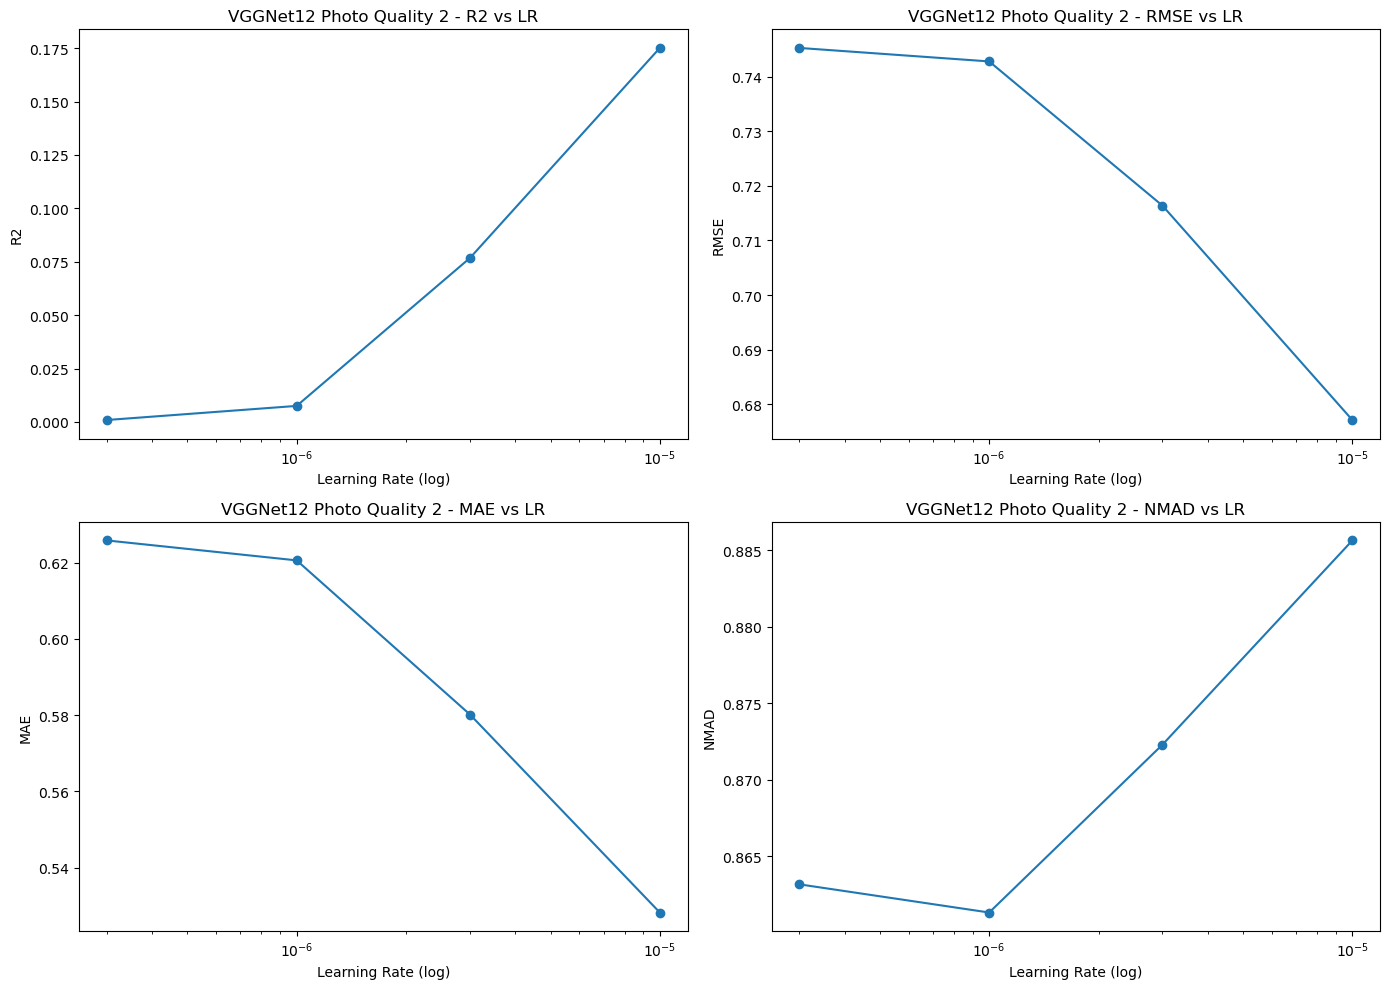


=== VGGNet12 Photo Quality 3 ===
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5726        0.5549  0.6988
      2        0.5422        0.5242  0.6074
      3        0.5367        0.5239  0.6085
      4        0.5357        0.5230  0.6076
      5        0.5349        0.5225  0.6077
      6        0.5345        0.5229  0.6081
      7        0.5337        0.5224  0.6087
      8        0.5335        0.5243  0.6098
      9        0.5323        0.5225  0.6124
     10        0.5312        0.5231  0.6109
     11        0.5301        0.5230  0.6098
     12        0.5299        0.5235  0.6089
     13        0.5287        0.5246  0.6089
     14        0.5299        0.5255  0.6090
     15        0.5280        0.5244  0.6124
     16        0.5280        0.5250  0.6108
Stopping since valid_loss has not improved in the last 10 epochs.


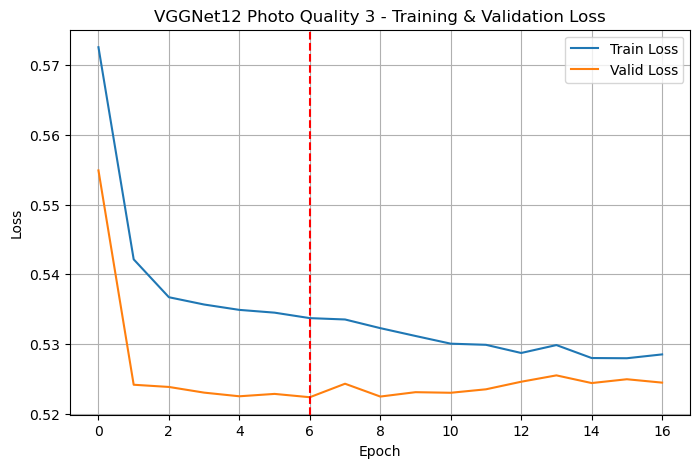

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5871        0.5828  0.6109
      2        0.5820        0.5765  0.6215
      3        0.5715        0.5465  0.6087
      4        0.5416        0.5242  0.6081
      5        0.5374        0.5237  0.6170
      6        0.5378        0.5238  0.6257
      7        0.5383        0.5239  0.6129
      8        0.5345        0.5232  0.6130
      9        0.5370        0.5236  0.6113
     10        0.5338        0.5231  0.6117
     11        0.5346        0.5230  0.6123
     12        0.5322        0.5228  0.6118
     13        0.5341        0.5229  0.6129
     14        0.5362        0.5234  0.6113
     15        0.5327        0.5228  0.6110
     16        0.5358        0.5232  0.6119
     17        0.5324        0.5233  0.6142
     18        0.5311        0.5224  0.6106
     19        0.5326        0.5231  0.6090
     20        0.5352        0.5230  0.6103
     21        0.5315        0.5

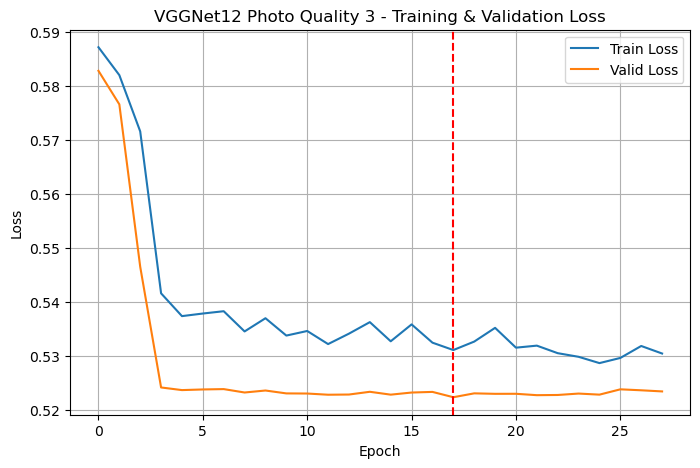

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5821        0.5802  0.6108
      2        0.5802        0.5787  0.6065
      3        0.5795        0.5772  0.6071
      4        0.5778        0.5756  0.6074
      5        0.5761        0.5739  0.6070
      6        0.5750        0.5716  0.6078
      7        0.5716        0.5669  0.6076
      8        0.5652        0.5544  0.6114
      9        0.5532        0.5382  0.6127
     10        0.5429        0.5275  0.6127
     11        0.5404        0.5259  0.6143
     12        0.5387        0.5256  0.6148
     13        0.5391        0.5255  0.6153
     14        0.5390        0.5255  0.6157
     15        0.5384        0.5251  0.6148
     16        0.5371        0.5248  0.6146
     17        0.5406        0.5252  0.6148
     18        0.5388        0.5252  0.6152
     19        0.5368        0.5249  0.6160
     20        0.5370        0.5247  0.6171
     21        0.5353        0.5

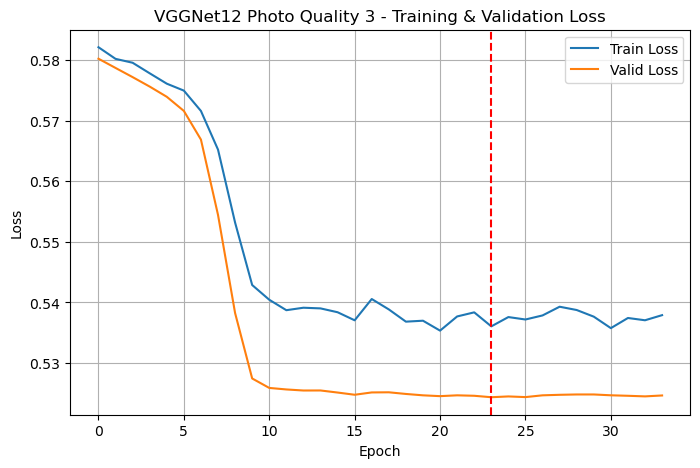

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5671        0.5655  0.6138
      2        0.5672        0.5650  0.6141
      3        0.5660        0.5646  0.6121
      4        0.5661        0.5641  0.6126
      5        0.5662        0.5637  0.6132
      6        0.5648        0.5633  0.6127
      7        0.5646        0.5628  0.6128
      8        0.5648        0.5624  0.6170
      9        0.5644        0.5620  0.6126
     10        0.5636        0.5616  0.6126
     11        0.5635        0.5612  0.6129
     12        0.5627        0.5608  0.6148
     13        0.5624        0.5604  0.6128
     14        0.5616        0.5600  0.6131
     15        0.5615        0.5596  0.6145
     16        0.5617        0.5591  0.6114
     17        0.5607        0.5587  0.6111
     18        0.5609        0.5583  0.6096
     19        0.5609        0.5579  0.6111
     20        0.5602        0.5575  0.6129
     21        0.5589        0.5

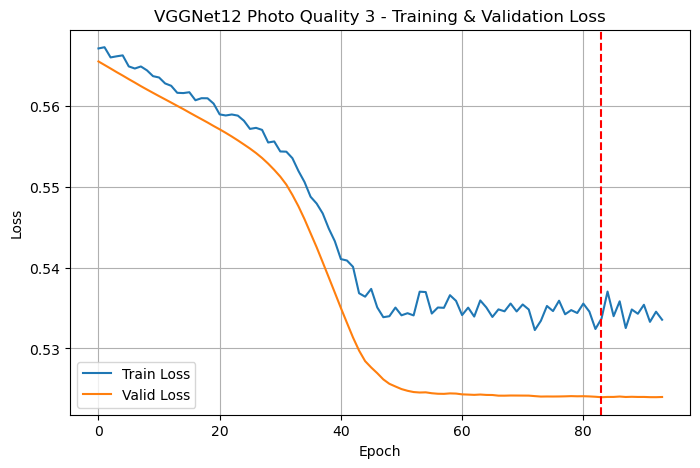

VGGNet12 Photo Quality 3 best params: {'lr': 1e-05, 'dropout': 0.5}


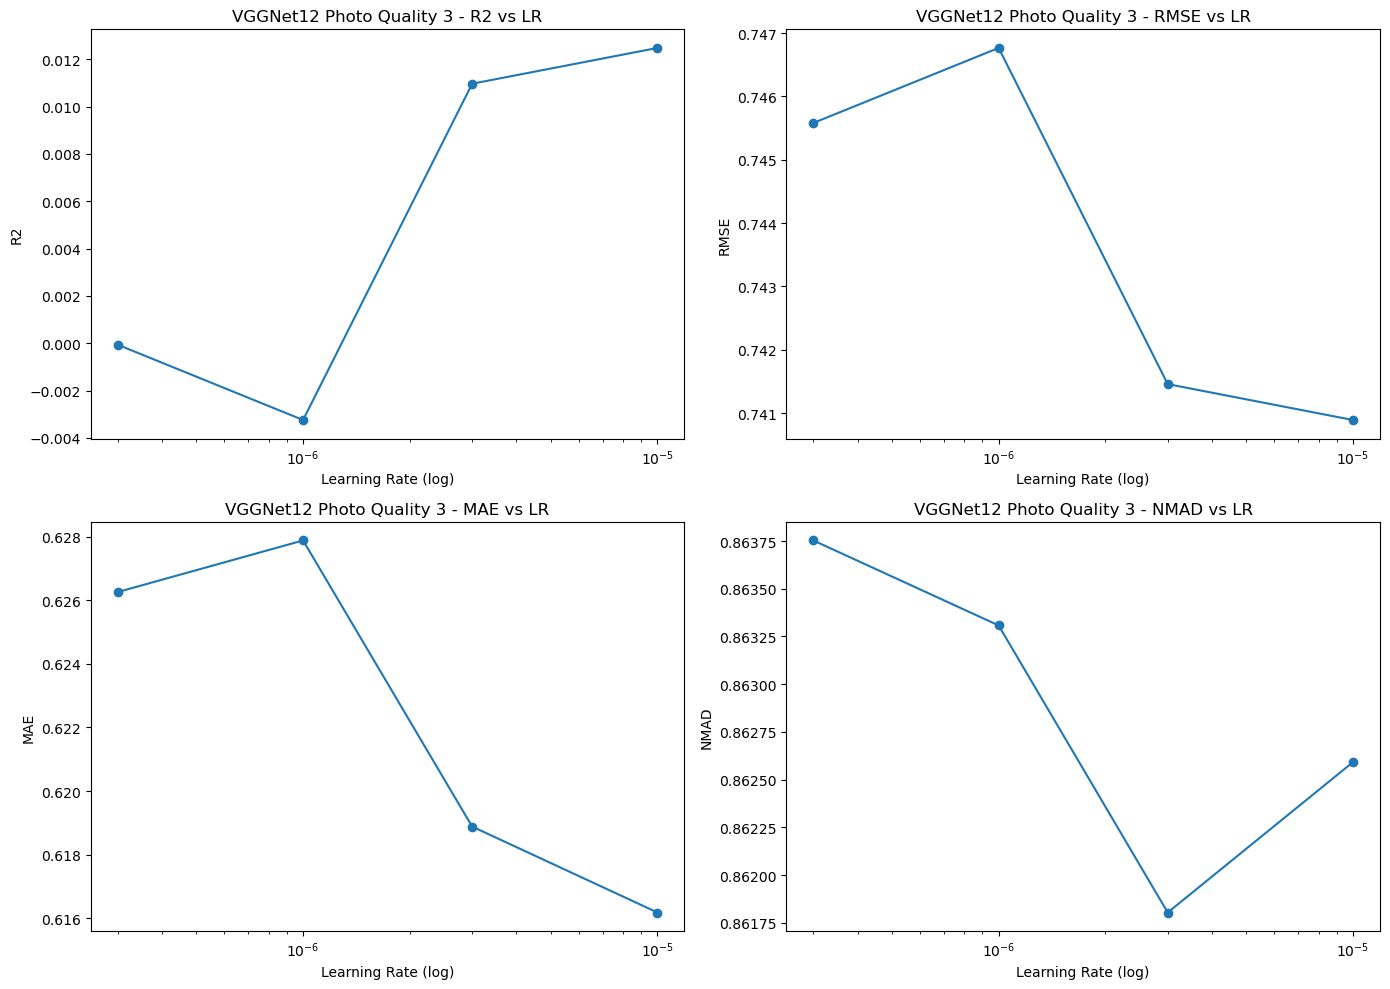

In [12]:
for q in range(4):
    print(f"\n=== VGGNet12 Photo Quality {q} ===")
    X_all = orig_images_flag0[q]
    mask = np.ones(X_all.shape[0], dtype=bool)
    mask[multi_obj_indices_flag0] = False
    X = X_all[mask]
    Y = selected_Y_flag0[:X_all.shape[0]][mask]
    n = min(X.shape[0], len(Y))
    X, Y = X[:n], Y[:n]

    # Train/Val/Test split
    X_trv, X_test, Y_trv, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    X_train, X_val, Y_train, Y_val = train_test_split(X_trv, Y_trv, test_size=0.25, random_state=42)

    # Run grid search
    start = time.time()
    net, params, res = run_skorch_grid_search_vgg(
        X_train, Y_train, X_val, Y_val, param_grid_vgg,
        in_ch=X_train.shape[1], in_h=X_train.shape[2], in_w=X_train.shape[3],
        title='VGGNet12 Photo', q=q
    )
    runtime[f'Photo q{q}'] = time.time() - start
    visualize_lr_results(res, 'VGGNet12 Photo', q)
    best_models_photo[q] = (net, Y_test, X_test)

### VGGNet12 on Spectra:


=== VGGNet12 Spectra Quality 0 ===
  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.5427        0.5263  15.5677
      2        0.5359        0.5246  15.5952
      3        0.5363        0.5251  15.6231
      4        0.5347        0.5244  15.6418
      5        0.5361        0.5249  15.6722
      6        0.5353        0.5257  15.6904
      7        0.5352        0.5250  15.6939
      8        0.5353        0.5239  15.7060
      9        0.5344        0.5216  15.7144
     10        0.5316        0.5197  15.7093
     11        0.5320        0.5170  15.7180
     12        0.5277        0.5163  15.7211
     13        0.5303        0.5183  15.7280
     14        0.5300        0.5174  15.7248
     15        0.5282        0.5154  15.7403
     16        0.5282        0.5152  15.7450
     17        0.5306        0.5142  15.7402
     18        0.5295        0.5139  15.7405
     19        0.5274        0.5135  15.7390
     20        0.52

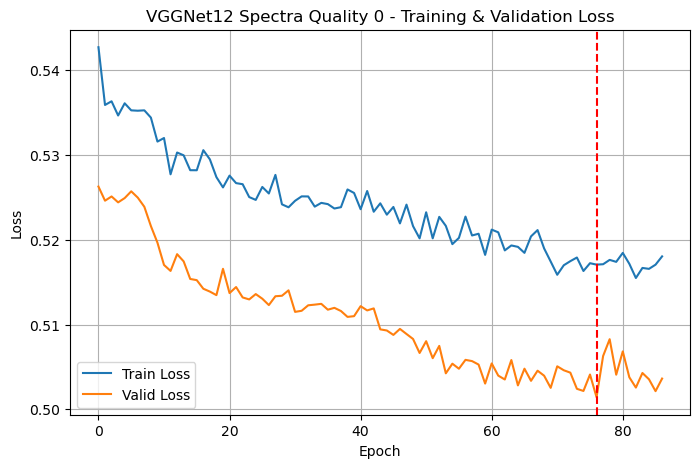

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.5350        0.5262  15.7090
      2        0.5349        0.5255  15.7122
      3        0.5346        0.5254  15.7112
      4        0.5340        0.5252  15.7103
      5        0.5338        0.5248  15.7136
      6        0.5341        0.5248  15.7224
      7        0.5335        0.5247  15.7275
      8        0.5345        0.5250  15.7176
      9        0.5337        0.5250  15.7231
     10        0.5334        0.5246  15.7279
     11        0.5343        0.5248  15.7285
     12        0.5335        0.5248  15.7291
     13        0.5332        0.5247  15.7259
     14        0.5338        0.5247  15.7332
     15        0.5338        0.5248  15.7264
     16        0.5332        0.5248  15.7297
     17        0.5343        0.5249  15.7216
     18        0.5337        0.5247  15.7249
     19        0.5344        0.5252  15.7271
Stopping since valid_loss has not improved in the last 

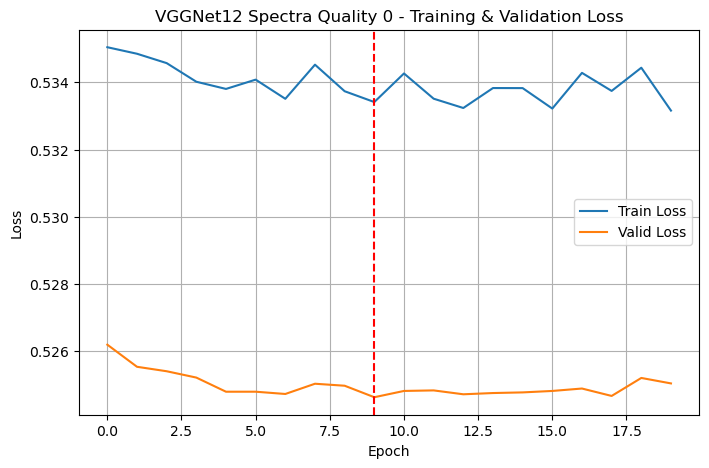

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.5504        0.5389  15.7159
      2        0.5424        0.5322  15.7216
      3        0.5380        0.5282  15.7134
      4        0.5344        0.5258  15.7106
      5        0.5354        0.5252  15.7161
      6        0.5353        0.5249  15.7215
      7        0.5353        0.5249  15.7154
      8        0.5360        0.5248  15.7225
      9        0.5349        0.5248  15.7275
     10        0.5351        0.5248  15.7222
     11        0.5350        0.5248  15.7134
     12        0.5368        0.5249  15.7166
     13        0.5351        0.5249  15.7186
     14        0.5349        0.5248  15.7260
     15        0.5348        0.5249  15.7197
     16        0.5347        0.5249  15.7196
     17        0.5348        0.5248  15.7213
     18        0.5344        0.5249  15.7131
     19        0.5357        0.5249  15.7214
Stopping since valid_loss has not improved in the last 

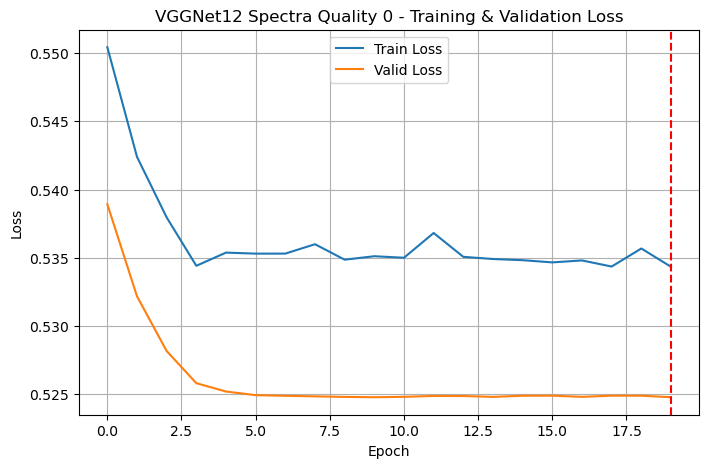

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.5575        0.5503  15.7205
      2        0.5517        0.5450  15.7079
      3        0.5470        0.5401  15.7078
      4        0.5448        0.5365  15.7188
      5        0.5423        0.5339  15.7128
      6        0.5390        0.5315  15.7055
      7        0.5375        0.5298  15.7110
      8        0.5374        0.5285  15.7141
      9        0.5361        0.5274  15.7228
     10        0.5368        0.5269  15.7203
     11        0.5348        0.5263  15.7110
     12        0.5377        0.5261  15.7185
     13        0.5356        0.5258  15.7074
     14        0.5347        0.5255  15.7069
     15        0.5348        0.5254  15.7191
     16        0.5356        0.5253  15.7146
     17        0.5343        0.5252  15.7177
     18        0.5365        0.5251  15.7067
     19        0.5343        0.5251  15.7197
     20        0.5333        0.5250  15.7097
     21   

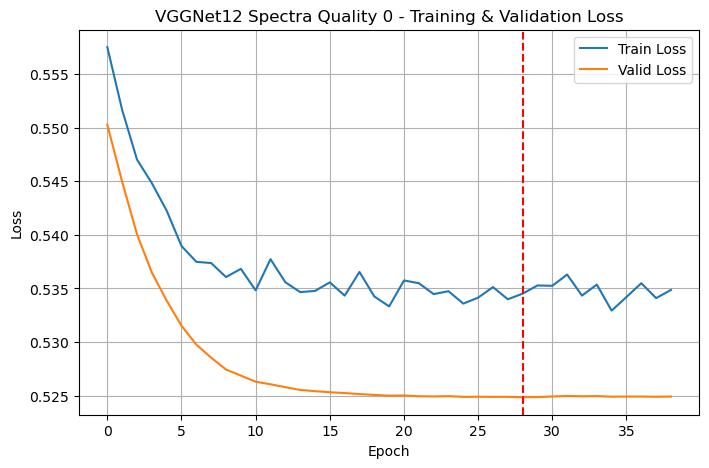

VGGNet12 Spectra Quality 0 best params: {'lr': 1e-05, 'dropout': 0.5}


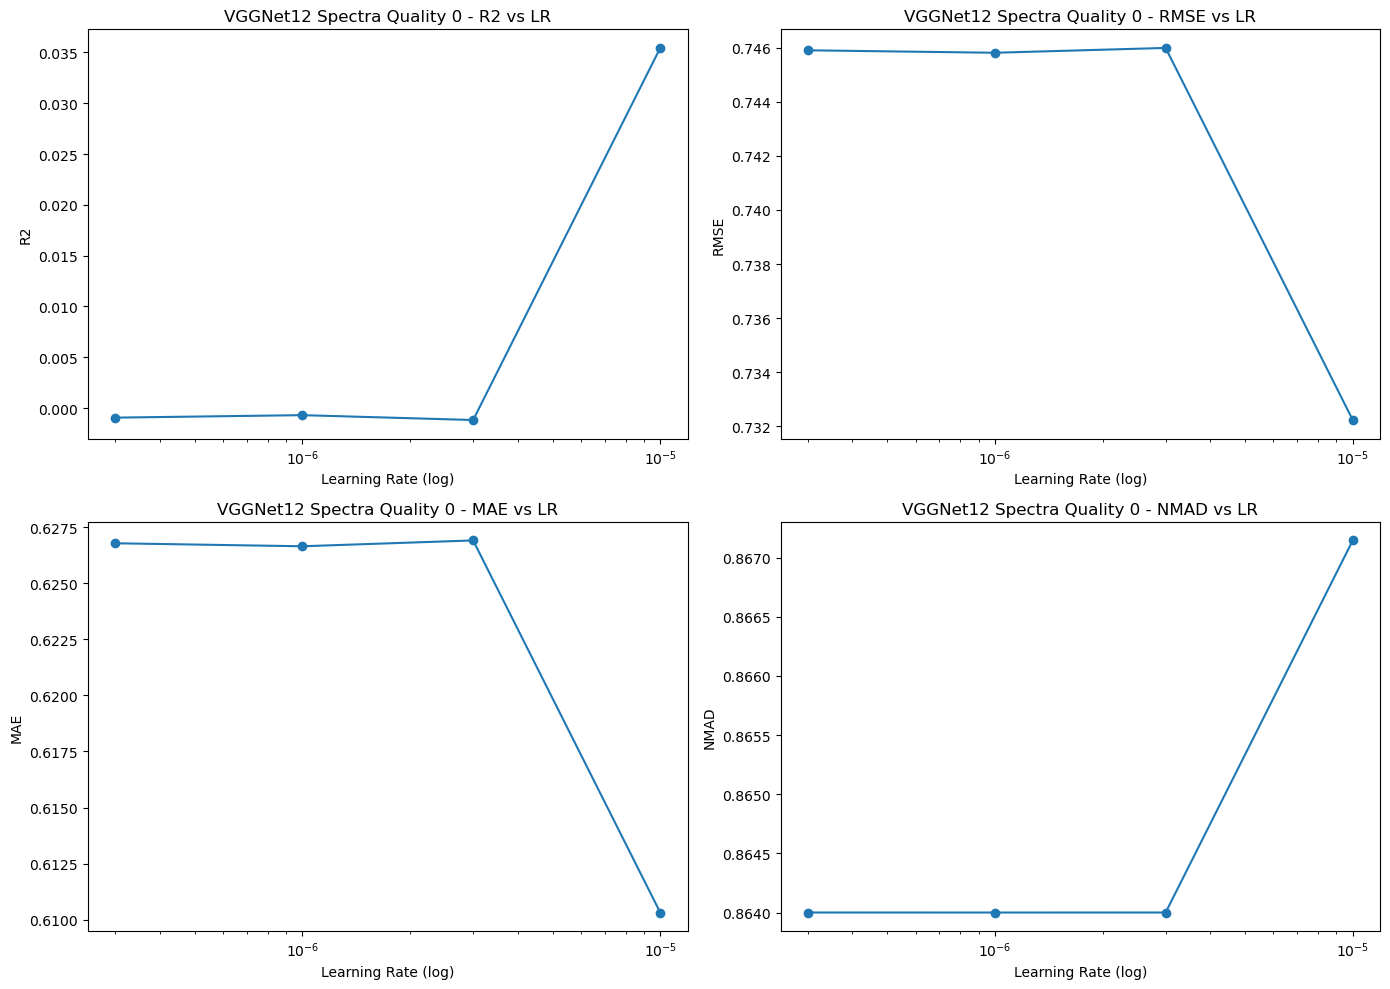


=== VGGNet12 Spectra Quality 1 ===
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5358        0.5251  7.8568
      2        0.5336        0.5246  7.8435
      3        0.5346        0.5249  7.8413
      4        0.5344        0.5247  7.8459
      5        0.5345        0.5244  7.8463
      6        0.5343        0.5243  7.8486
      7        0.5333        0.5229  7.8499
      8        0.5289        0.5137  7.8503
      9        0.5241        0.5103  7.8459
     10        0.5210        0.5106  7.8467
     11        0.5223        0.5094  7.8438
     12        0.5222        0.5092  7.8470
     13        0.5194        0.5095  7.8470
     14        0.5196        0.5093  7.8433
     15        0.5206        0.5088  7.8430
     16        0.5198        0.5086  7.8439
     17        0.5178        0.5084  7.8464
     18        0.5213        0.5096  7.8432
     19        0.5199        0.5085  7.8409
     20        0.5197        0.5079  7.8

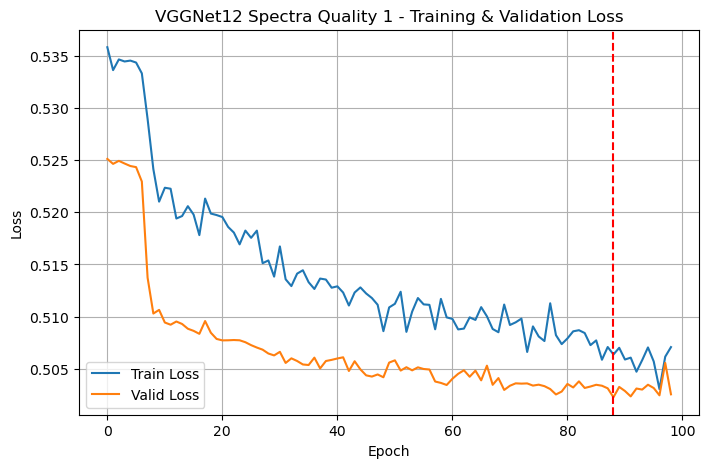

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5724        0.5482  7.8310
      2        0.5445        0.5270  7.8333
      3        0.5376        0.5250  7.8326
      4        0.5388        0.5252  7.8319
      5        0.5373        0.5250  7.8327
      6        0.5363        0.5253  7.8360
      7        0.5380        0.5250  7.8390
      8        0.5355        0.5248  7.8356
      9        0.5370        0.5251  7.8356
     10        0.5368        0.5248  7.8352
     11        0.5355        0.5246  7.8373
     12        0.5377        0.5249  7.8494
     13        0.5370        0.5251  7.8475
     14        0.5369        0.5246  7.8377
     15        0.5363        0.5244  7.8417
     16        0.5360        0.5244  7.8427
     17        0.5366        0.5245  7.8426
     18        0.5349        0.5240  7.8403
     19        0.5370        0.5237  7.8418
     20        0.5354        0.5223  7.8435
     21        0.5363        0.5

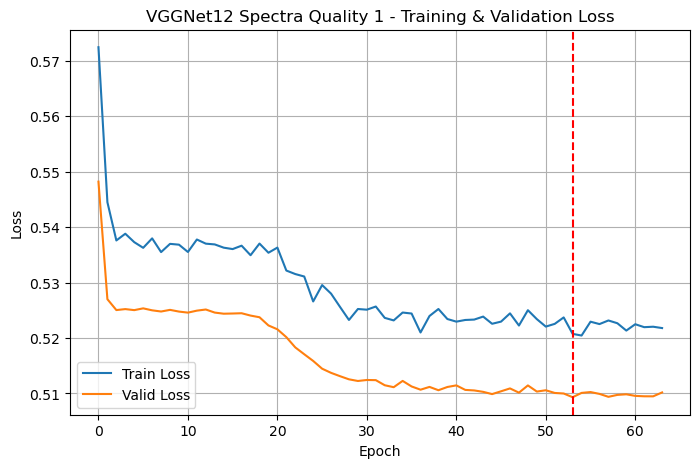

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5635        0.5525  7.8402
      2        0.5529        0.5422  7.8372
      3        0.5448        0.5345  7.8449
      4        0.5425        0.5302  7.8491
      5        0.5377        0.5274  7.8513
      6        0.5360        0.5259  7.8492
      7        0.5341        0.5252  7.8523
      8        0.5365        0.5251  7.8509
      9        0.5343        0.5248  7.8423
     10        0.5358        0.5248  7.8517
     11        0.5348        0.5247  7.8530
     12        0.5361        0.5248  7.8493
     13        0.5346        0.5247  7.8496
     14        0.5359        0.5247  7.8495
     15        0.5385        0.5248  7.8496
     16        0.5373        0.5249  7.8516
     17        0.5364        0.5248  7.8504
     18        0.5354        0.5248  7.8514
     19        0.5347        0.5247  7.8489
     20        0.5349        0.5247  7.8528
Stopping since valid_loss has no

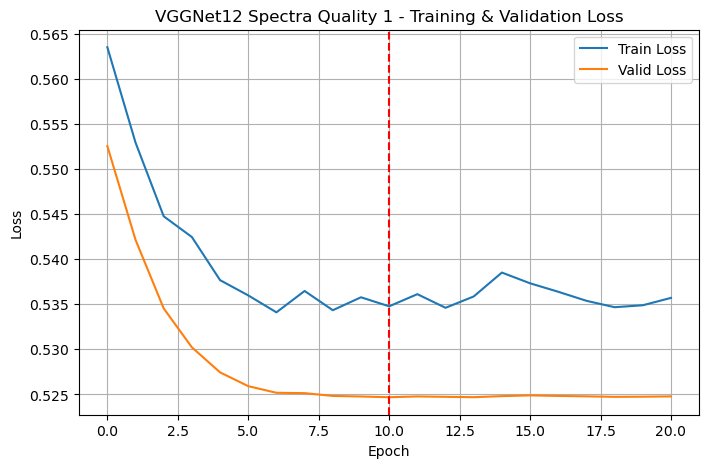

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5421        0.5356  7.8476
      2        0.5408        0.5341  7.8453
      3        0.5395        0.5329  7.8492
      4        0.5389        0.5319  7.8474
      5        0.5379        0.5310  7.8491
      6        0.5376        0.5303  7.8487
      7        0.5368        0.5296  7.8454
      8        0.5365        0.5291  7.8501
      9        0.5361        0.5286  7.8505
     10        0.5356        0.5281  7.8454
     11        0.5361        0.5278  7.8462
     12        0.5357        0.5275  7.8506
     13        0.5355        0.5272  7.8433
     14        0.5351        0.5269  7.8461
     15        0.5352        0.5267  7.8474
     16        0.5348        0.5265  7.8483
     17        0.5345        0.5263  7.8478
     18        0.5342        0.5261  7.8493
     19        0.5349        0.5260  7.8455
     20        0.5335        0.5259  7.8492
     21        0.5342        0.5

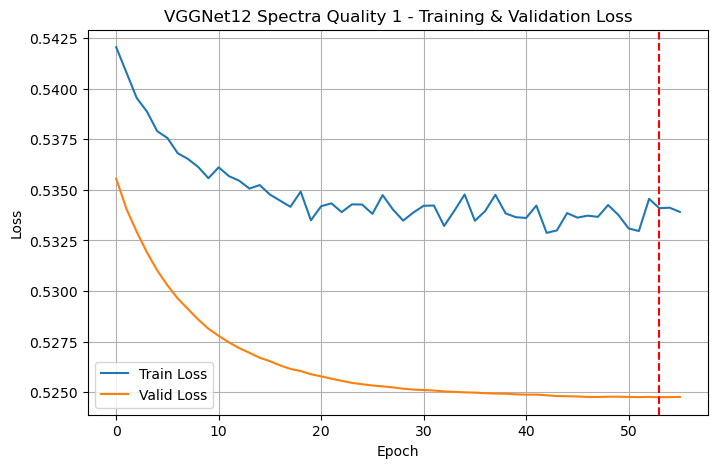

VGGNet12 Spectra Quality 1 best params: {'lr': 1e-05, 'dropout': 0.5}


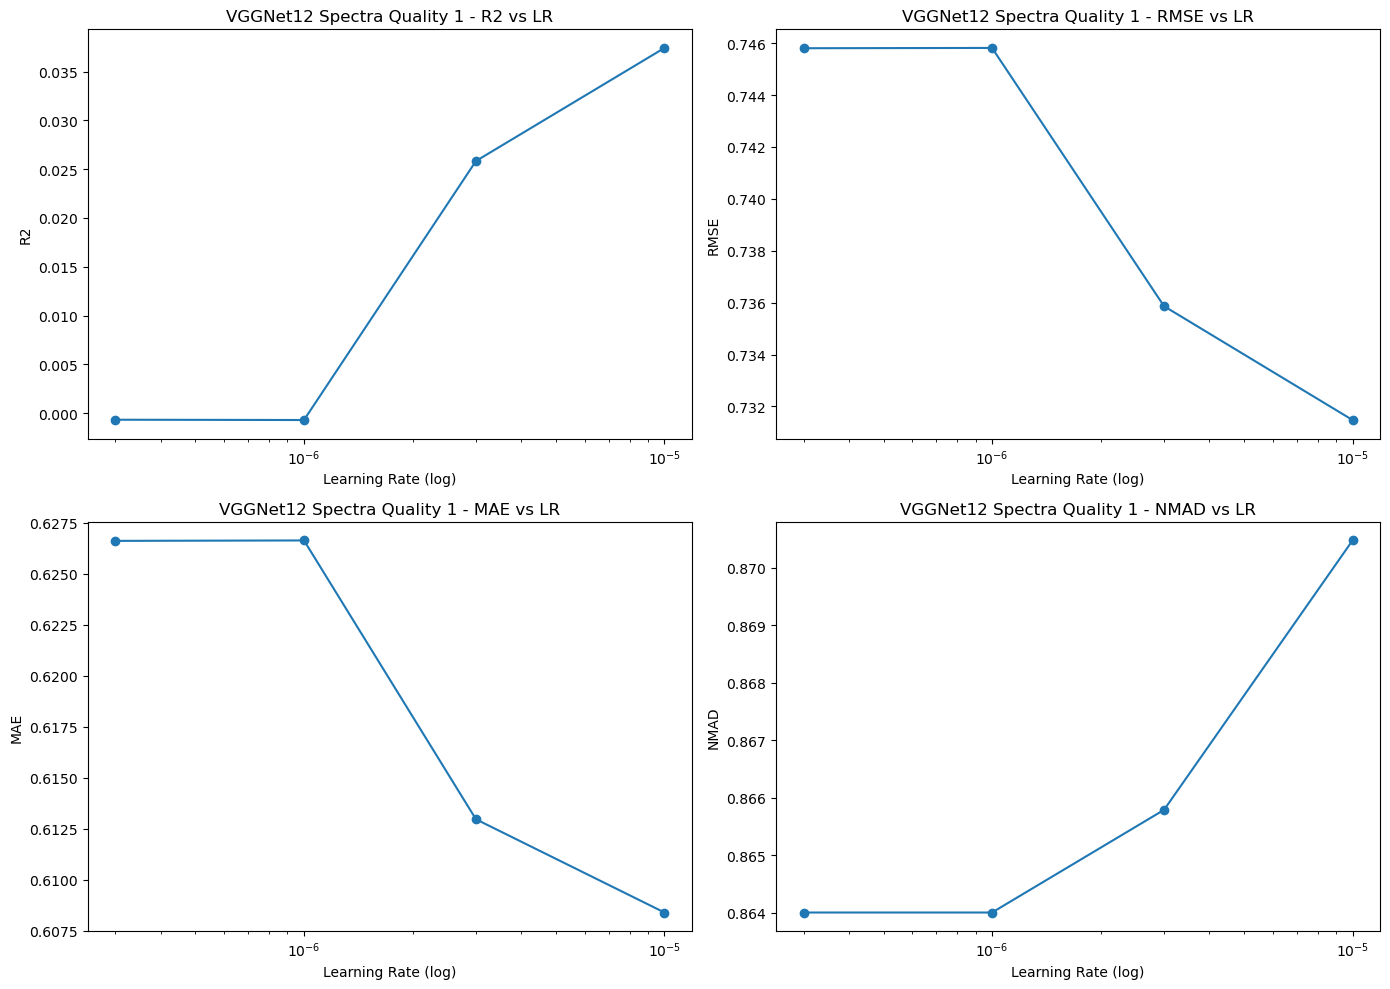


=== VGGNet12 Spectra Quality 2 ===
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5427        0.5262  4.1809
      2        0.5349        0.5246  4.1735
      3        0.5342        0.5245  4.1743
      4        0.5356        0.5243  4.1687
      5        0.5343        0.5240  4.1716
      6        0.5340        0.5218  4.1722
      7        0.5290        0.5150  4.1722
      8        0.5270        0.5114  4.1749
      9        0.5237        0.5087  4.1737
     10        0.5244        0.5097  4.1804
     11        0.5205        0.5077  4.1742
     12        0.5208        0.5085  4.1744
     13        0.5195        0.5082  4.1731
     14        0.5187        0.5067  4.1755
     15        0.5191        0.5064  4.1750
     16        0.5185        0.5069  4.1744
     17        0.5187        0.5062  4.1755
     18        0.5180        0.5067  4.1761
     19        0.5181        0.5058  4.1745
     20        0.5178        0.5072  4.1

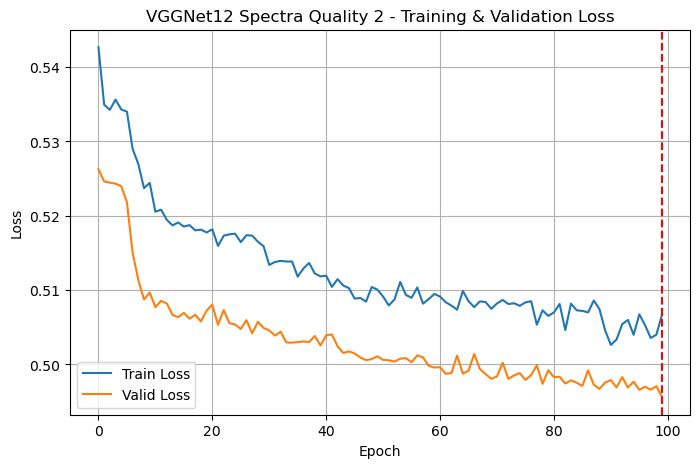

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5501        0.5377  4.1788
      2        0.5395        0.5282  4.1727
      3        0.5367        0.5259  4.1703
      4        0.5359        0.5253  4.1676
      5        0.5350        0.5250  4.1757
      6        0.5360        0.5249  4.1851
      7        0.5339        0.5248  4.1808
      8        0.5350        0.5249  4.1826
      9        0.5354        0.5248  4.1796
     10        0.5345        0.5248  4.1860
     11        0.5341        0.5246  4.1798
     12        0.5359        0.5248  4.1790
     13        0.5345        0.5247  4.1811
     14        0.5339        0.5245  4.1727
     15        0.5340        0.5243  4.1729
     16        0.5340        0.5241  4.1810
     17        0.5338        0.5237  4.1825
     18        0.5332        0.5231  4.1864
     19        0.5345        0.5226  4.1898
     20        0.5306        0.5209  4.1909
     21        0.5296        0.5

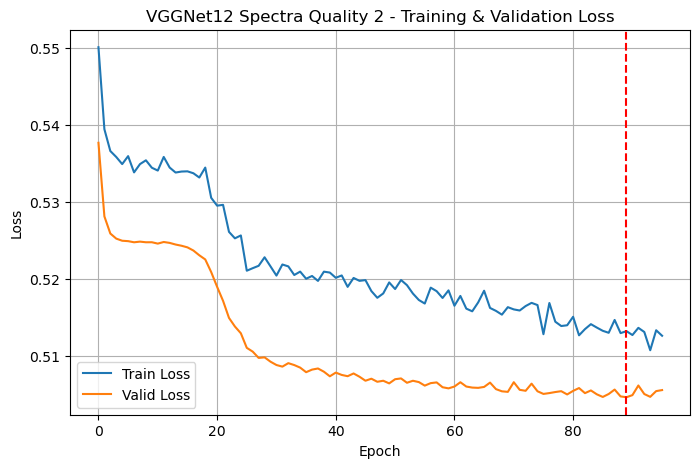

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5643        0.5582  4.1778
      2        0.5591        0.5521  4.1827
      3        0.5537        0.5458  4.1769
      4        0.5488        0.5400  4.1742
      5        0.5449        0.5353  4.1736
      6        0.5416        0.5316  4.1800
      7        0.5368        0.5286  4.1819
      8        0.5374        0.5270  4.1805
      9        0.5362        0.5262  4.1832
     10        0.5358        0.5256  4.1823
     11        0.5347        0.5252  4.1794
     12        0.5354        0.5251  4.1793
     13        0.5369        0.5251  4.1800
     14        0.5359        0.5250  4.1791
     15        0.5341        0.5248  4.1781
     16        0.5359        0.5248  4.1788
     17        0.5370        0.5248  4.1793
     18        0.5353        0.5248  4.1824
     19        0.5351        0.5248  4.1790
     20        0.5368        0.5248  4.1693
     21        0.5346        0.5

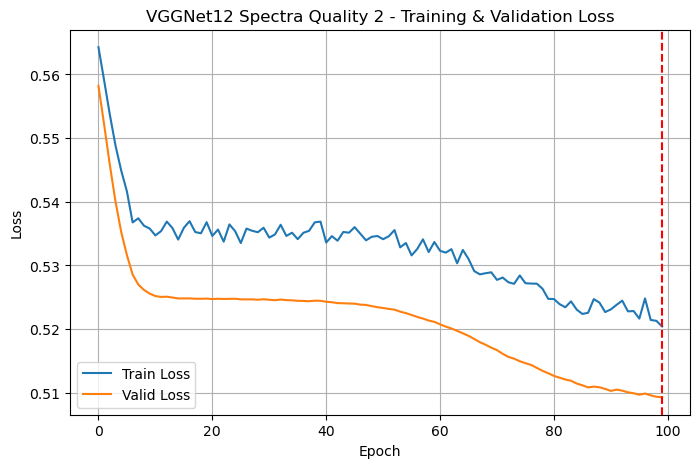

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5709        0.5663  4.1800
      2        0.5672        0.5627  4.1770
      3        0.5645        0.5595  4.1773
      4        0.5612        0.5566  4.1810
      5        0.5586        0.5536  4.1784
      6        0.5564        0.5506  4.1824
      7        0.5539        0.5480  4.1861
      8        0.5523        0.5456  4.1902
      9        0.5500        0.5434  4.1890
     10        0.5487        0.5416  4.1868
     11        0.5479        0.5400  4.1883
     12        0.5461        0.5384  4.1852
     13        0.5454        0.5371  4.1857
     14        0.5443        0.5357  4.1862
     15        0.5429        0.5345  4.1877
     16        0.5411        0.5334  4.1897
     17        0.5410        0.5324  4.1869
     18        0.5402        0.5315  4.1877
     19        0.5382        0.5306  4.1901
     20        0.5389        0.5299  4.1887
     21        0.5385        0.5

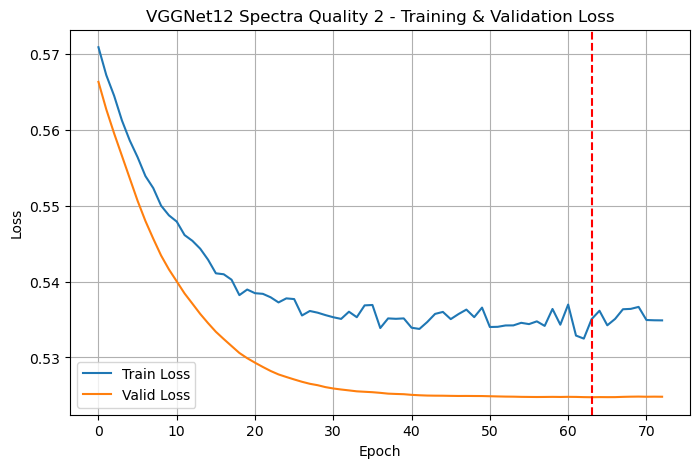

VGGNet12 Spectra Quality 2 best params: {'lr': 1e-05, 'dropout': 0.5}


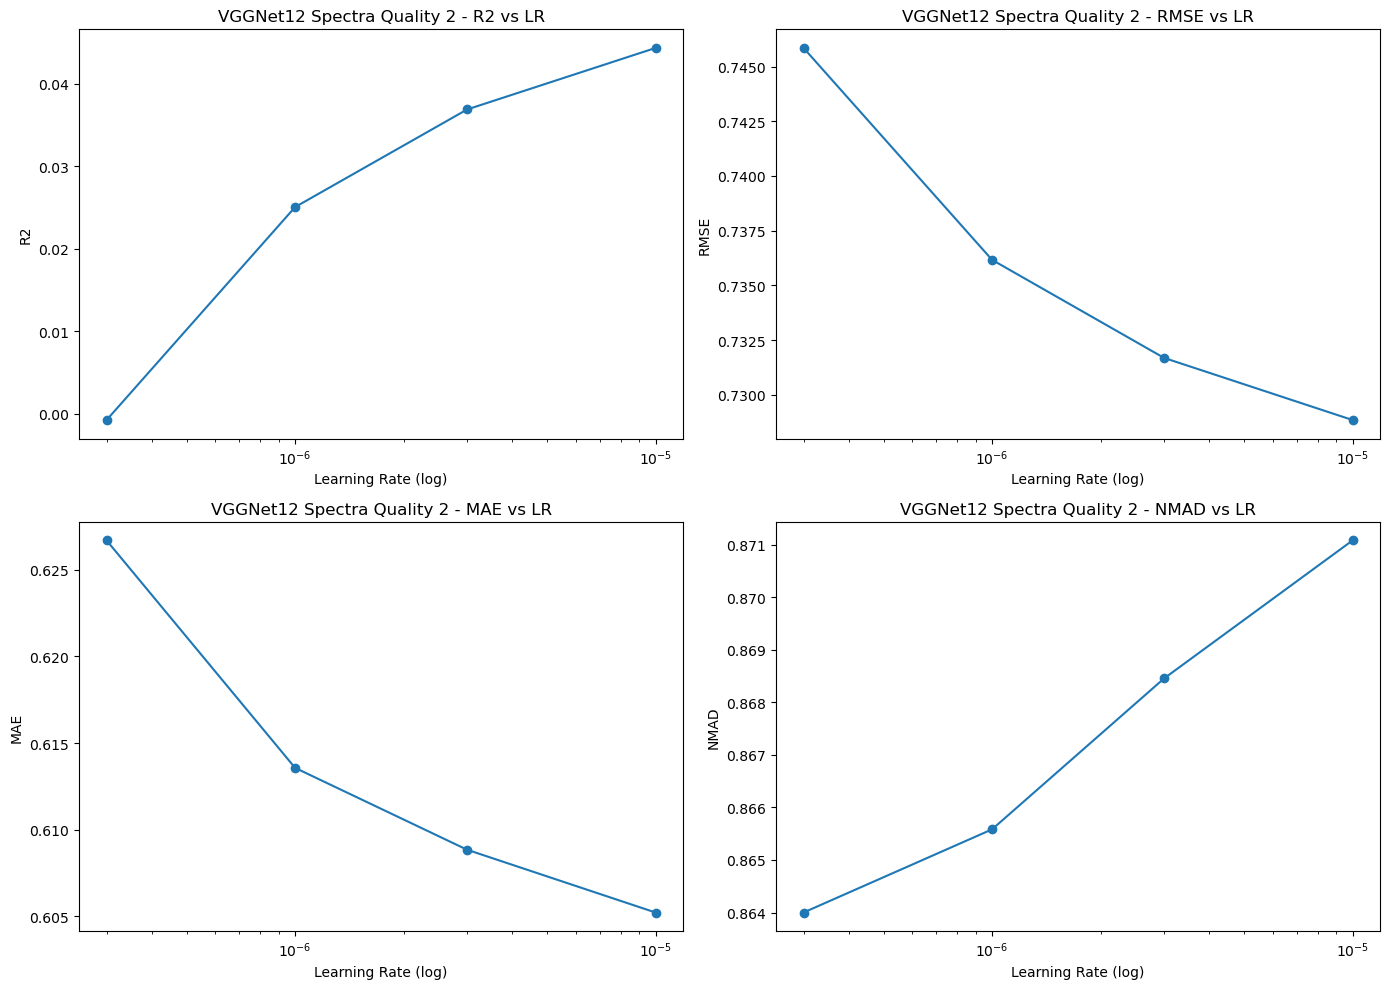


=== VGGNet12 Spectra Quality 3 ===
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5595        0.5299  2.2632
      2        0.5362        0.5250  2.2534
      3        0.5363        0.5257  2.2553
      4        0.5359        0.5247  2.2523
      5        0.5357        0.5215  2.2547
      6        0.5317        0.5184  2.2576
      7        0.5309        0.5162  2.2580
      8        0.5262        0.5091  2.2573
      9        0.5219        0.5115  2.2579
     10        0.5232        0.5104  2.2582
     11        0.5238        0.5070  2.2582
     12        0.5212        0.5077  2.2588
     13        0.5227        0.5088  2.2573
     14        0.5217        0.5062  2.2575
     15        0.5241        0.5078  2.2581
     16        0.5189        0.5063  2.2579
     17        0.5216        0.5080  2.2587
     18        0.5205        0.5077  2.2581
     19        0.5213        0.5097  2.2565
     20        0.5204        0.5063  2.2

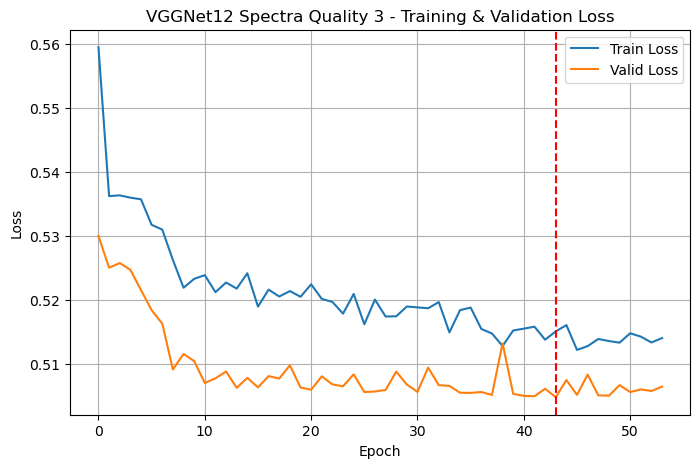

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5394        0.5319  2.2578
      2        0.5370        0.5295  2.2559
      3        0.5350        0.5275  2.2548
      4        0.5347        0.5264  2.2556
      5        0.5344        0.5257  2.2579
      6        0.5342        0.5251  2.2583
      7        0.5344        0.5251  2.2596
      8        0.5330        0.5249  2.2599
      9        0.5337        0.5248  2.2610
     10        0.5340        0.5248  2.2591
     11        0.5338        0.5247  2.2601
     12        0.5337        0.5246  2.2611
     13        0.5338        0.5246  2.2601
     14        0.5331        0.5245  2.2590
     15        0.5343        0.5244  2.2608
     16        0.5333        0.5243  2.2607
     17        0.5335        0.5241  2.2602
     18        0.5327        0.5236  2.2616
     19        0.5324        0.5228  2.2605
     20        0.5323        0.5217  2.2604
     21        0.5312        0.5

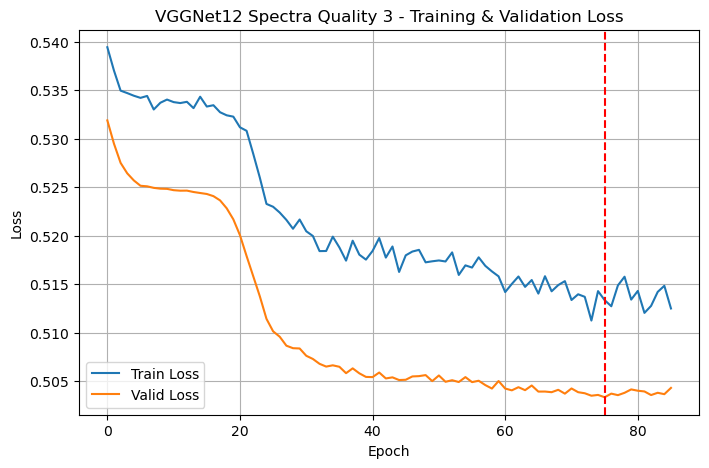

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5435        0.5372  2.2369
      2        0.5420        0.5354  2.2360
      3        0.5404        0.5338  2.2368
      4        0.5394        0.5323  2.2376
      5        0.5381        0.5309  2.2395
      6        0.5376        0.5298  2.2372
      7        0.5366        0.5288  2.2383
      8        0.5361        0.5280  2.2385
      9        0.5356        0.5273  2.2398
     10        0.5347        0.5267  2.2390
     11        0.5343        0.5262  2.2384
     12        0.5343        0.5260  2.2381
     13        0.5341        0.5256  2.2384
     14        0.5348        0.5255  2.2387
     15        0.5346        0.5254  2.2397
     16        0.5344        0.5253  2.2391
     17        0.5333        0.5252  2.2387
     18        0.5341        0.5251  2.2382
     19        0.5335        0.5250  2.2392
     20        0.5341        0.5249  2.2392
     21        0.5346        0.5

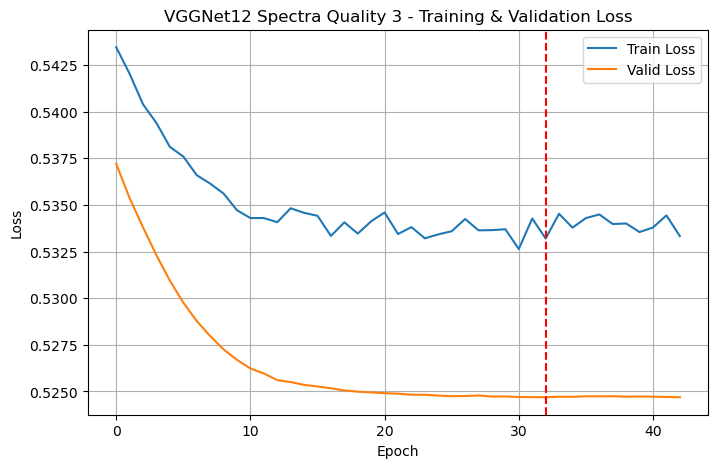

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5754        0.5726  2.2370
      2        0.5737        0.5707  2.2358
      3        0.5716        0.5689  2.2359
      4        0.5702        0.5672  2.2373
      5        0.5683        0.5654  2.2374
      6        0.5668        0.5635  2.2519
      7        0.5655        0.5614  2.2529
      8        0.5637        0.5593  2.2519
      9        0.5615        0.5571  2.2525
     10        0.5598        0.5548  2.2423
     11        0.5579        0.5524  2.2386
     12        0.5561        0.5501  2.2389
     13        0.5537        0.5478  2.2391
     14        0.5519        0.5458  2.2398
     15        0.5499        0.5437  2.2419
     16        0.5493        0.5419  2.2400
     17        0.5477        0.5402  2.2392
     18        0.5451        0.5385  2.2389
     19        0.5443        0.5371  2.2398
     20        0.5432        0.5357  2.2394
     21        0.5415        0.5

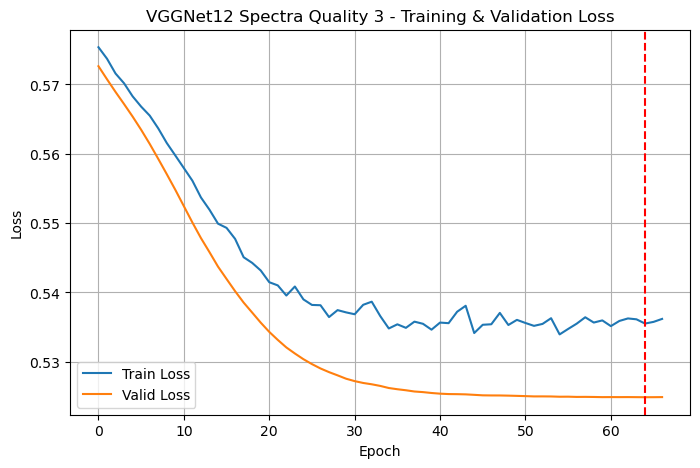

VGGNet12 Spectra Quality 3 best params: {'lr': 3e-06, 'dropout': 0.5}


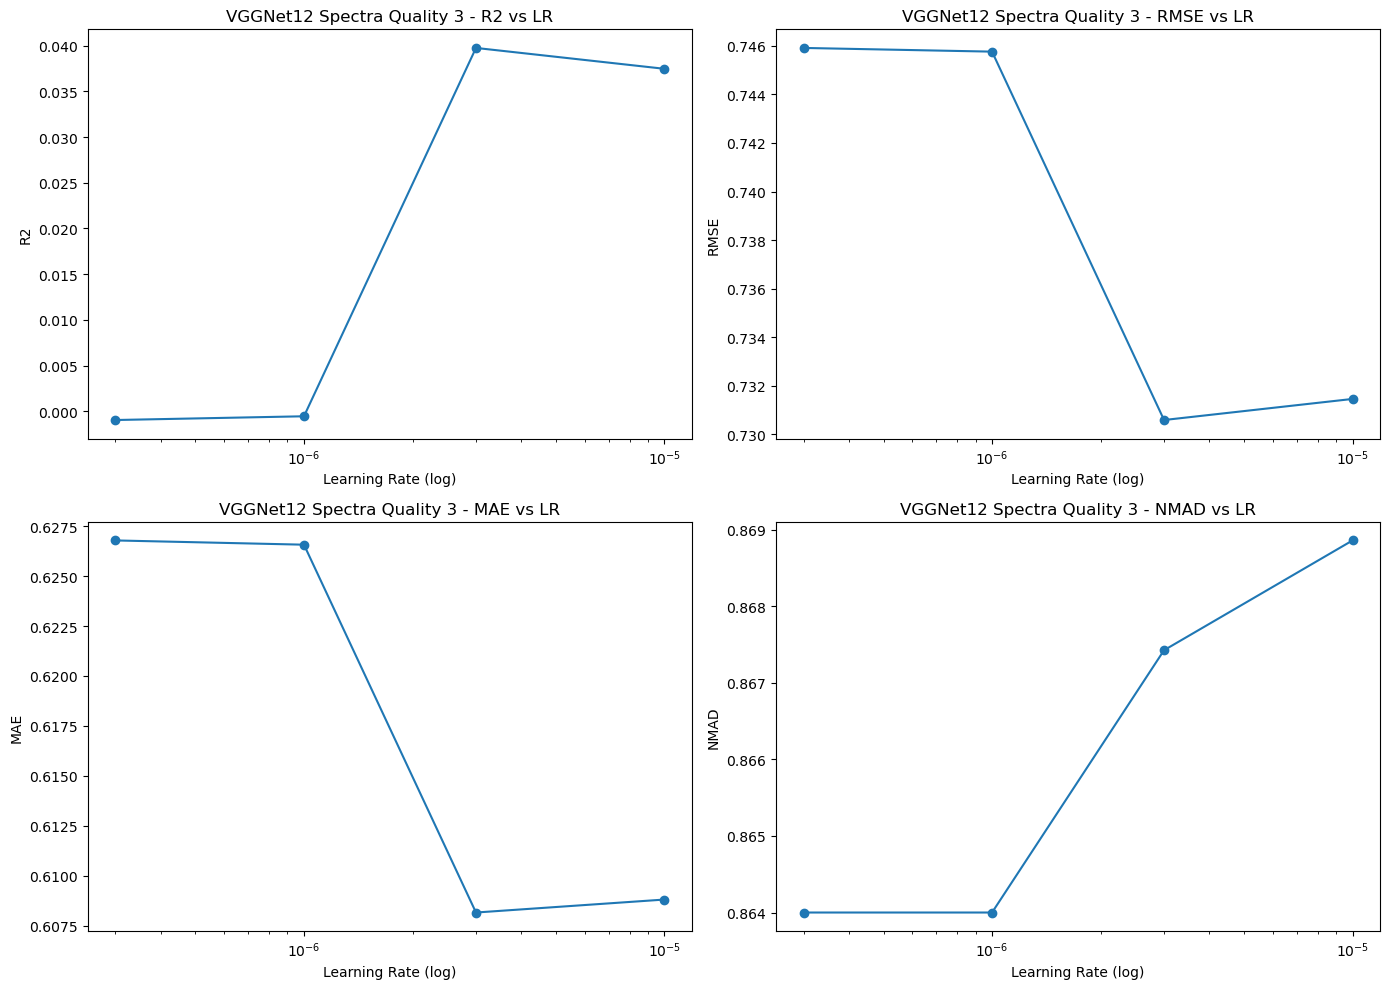

In [13]:
for q in range(4):
    print(f"\n=== VGGNet12 Spectra Quality {q} ===")
    X_all = normalized_filtered_spectra[q]
    mask = np.ones(X_all.shape[0], dtype=bool)
    mask[multi_obj_indices_flag0] = False
    X = X_all[mask]
    Y = selected_Y_flag0[:X_all.shape[0]][mask]
    n = min(X.shape[0], len(Y))
    X, Y = X[:n], Y[:n]

    # Reshape to 4D
    X_4d = X.reshape(X.shape[0], 1, 1, X.shape[1])

    # Train/Val/Test split
    X_trv, X_test, Y_trv, Y_test = train_test_split(X_4d, Y, test_size=0.2, random_state=42)
    X_train, X_val, Y_train, Y_val = train_test_split(X_trv, Y_trv, test_size=0.25, random_state=42)

    # Run grid search
    start = time.time()
    net, params, res = run_skorch_grid_search_vgg(
        X_train, Y_train, X_val, Y_val, param_grid_vgg,
        in_ch=1, in_h=1, in_w=X_train.shape[-1],
        title='VGGNet12 Spectra', q=q
    )
    runtime[f'Spec q{q}'] = time.time() - start
    visualize_lr_results(res, 'VGGNet12 Spectra', q)
    best_models_spec[q] = (net, Y_test, X_test)

### Compile all results:

### Visualization of comparative metrics:

In [14]:
comparison_photo = {}
comparison_spec = {}

# Evaluate Photo models
for q, (net, Y_test, X_test) in best_models_photo.items():
    Y_pred = net.predict(X_test)
    mae = mean_absolute_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)
    err = Y_pred - Y_test
    nmad = 1.4826 * np.median(np.abs(err - np.median(err)))
    rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
    comparison_photo[f'Photo q{q}'] = {'r2': r2, 'mae': mae, 'nmad': nmad, 'rmse': rmse}

In [15]:
for q, (net, Y_test, X_test) in best_models_spec.items():
    Y_pred = net.predict(X_test)
    mae = mean_absolute_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)
    err = Y_pred - Y_test
    nmad = 1.4826 * np.median(np.abs(err - np.median(err)))
    rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
    comparison_spec[f'Spec q{q}'] = {'r2': r2, 'mae': mae, 'nmad': nmad, 'rmse': rmse}

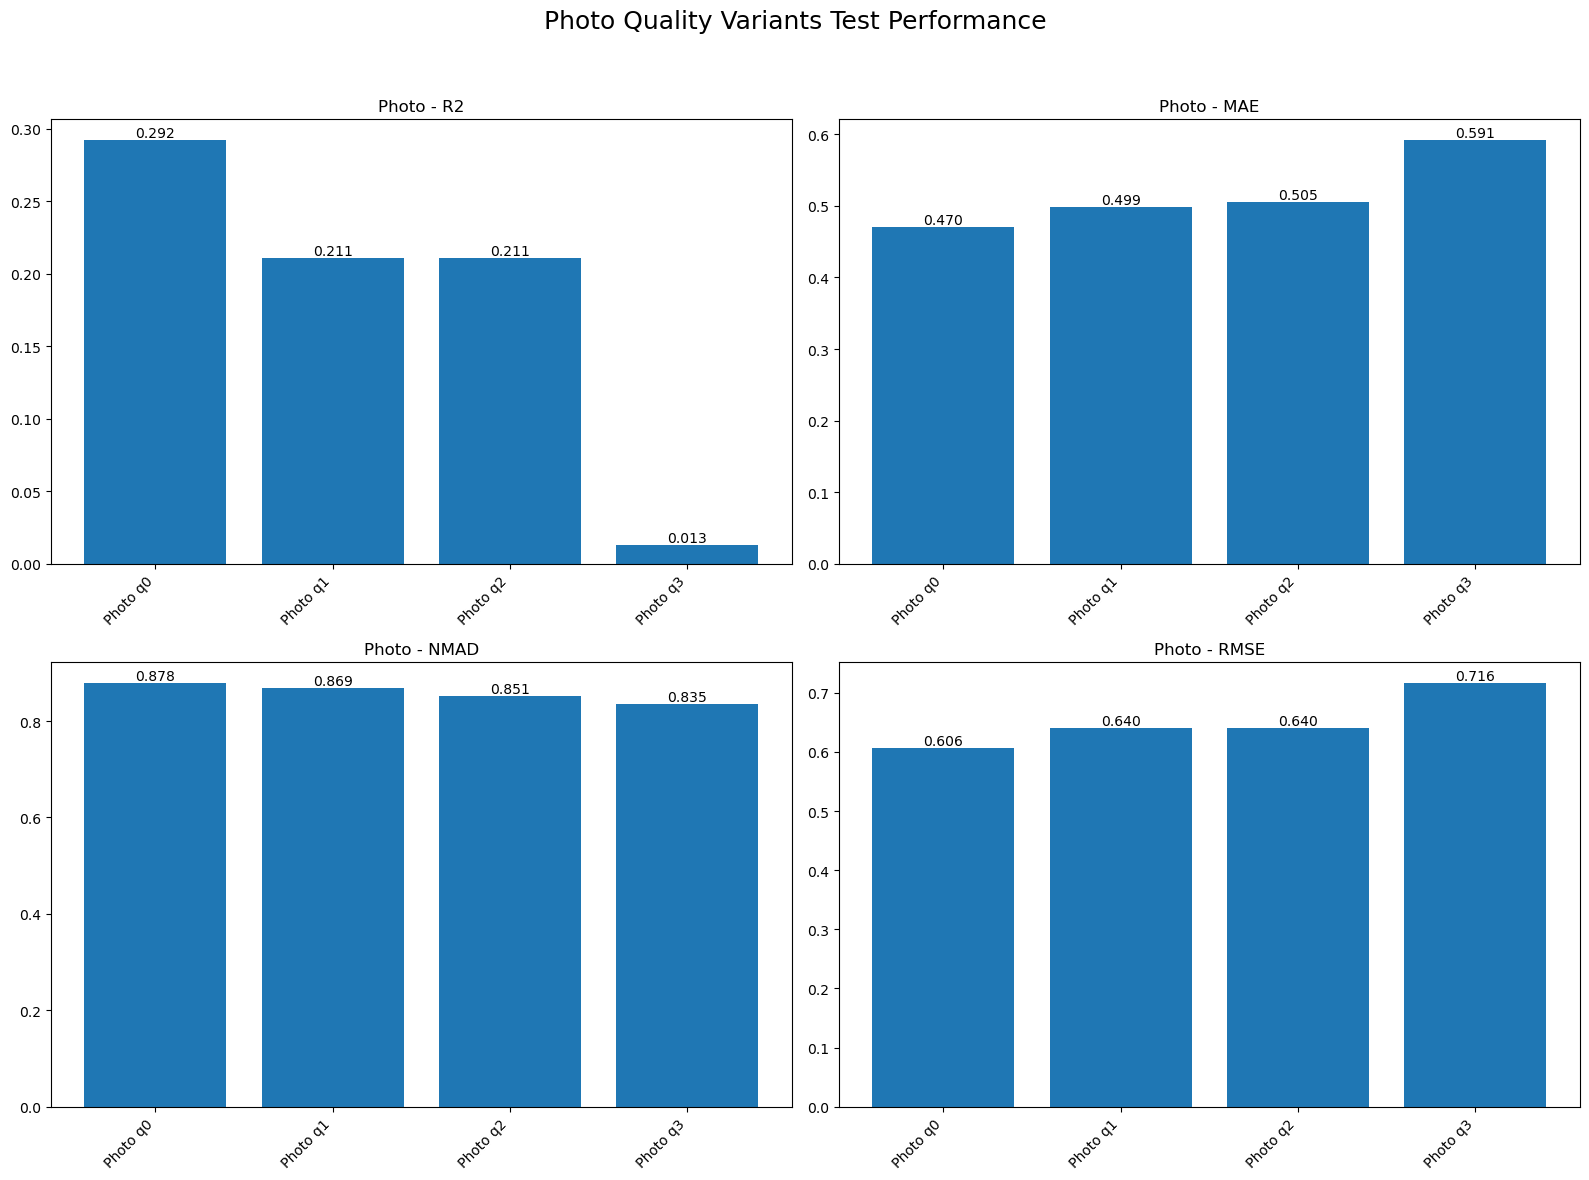

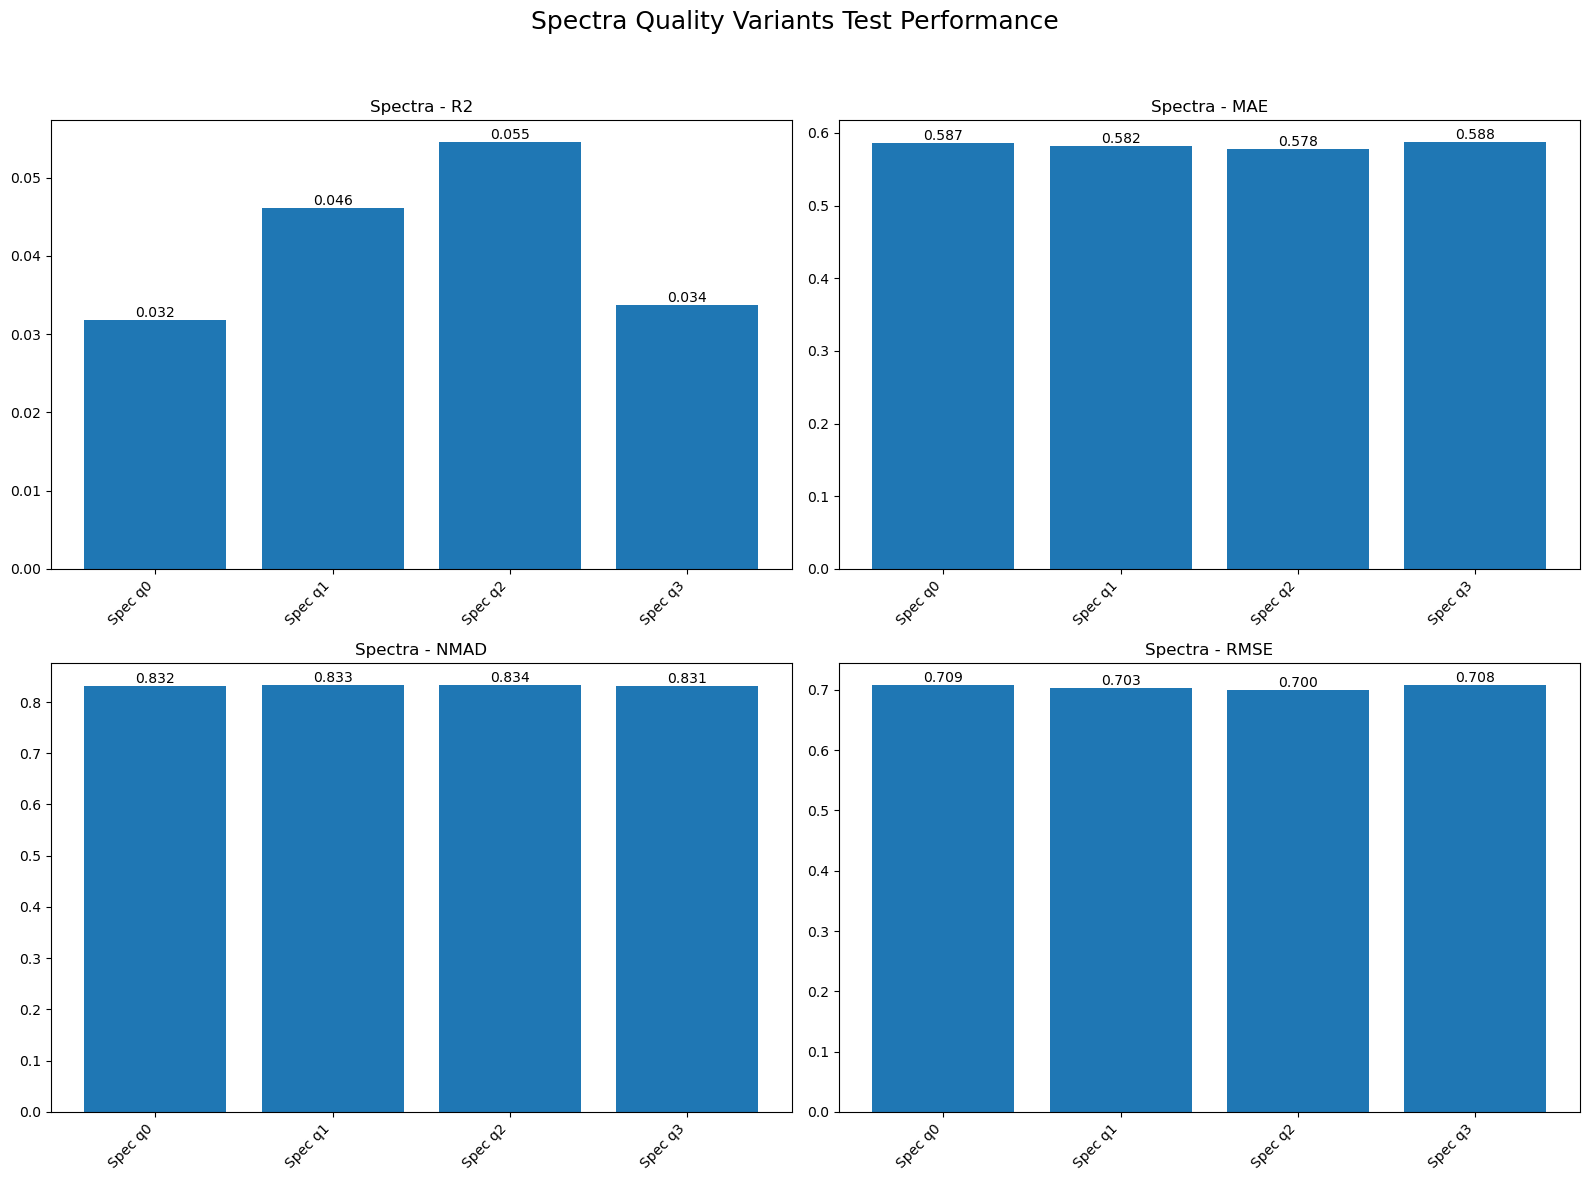

In [16]:
def plot_comparison(comp, title):
    metrics = ['r2','mae','nmad','rmse']
    methods = list(comp.keys())
    values = {m: [comp[k][m] for k in methods] for m in metrics}
    x = np.arange(len(methods))
    fig, axs = plt.subplots(2,2, figsize=(16,12))
    axs = axs.flatten()
    for i, m in enumerate(metrics):
        axs[i].bar(x, values[m])
        axs[i].set_xticks(x)
        axs[i].set_xticklabels(methods, rotation=45, ha='right')
        axs[i].set_title(f'{title} - {m.upper()}')
        for j, v in enumerate(values[m]): axs[i].text(j, v, f"{v:.3f}", ha='center', va='bottom')
    plt.suptitle(f'{title} Quality Variants Test Performance', fontsize=18)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

plot_comparison(comparison_photo, 'Photo')
plot_comparison(comparison_spec, 'Spectra')

### Visualization of runtimes:

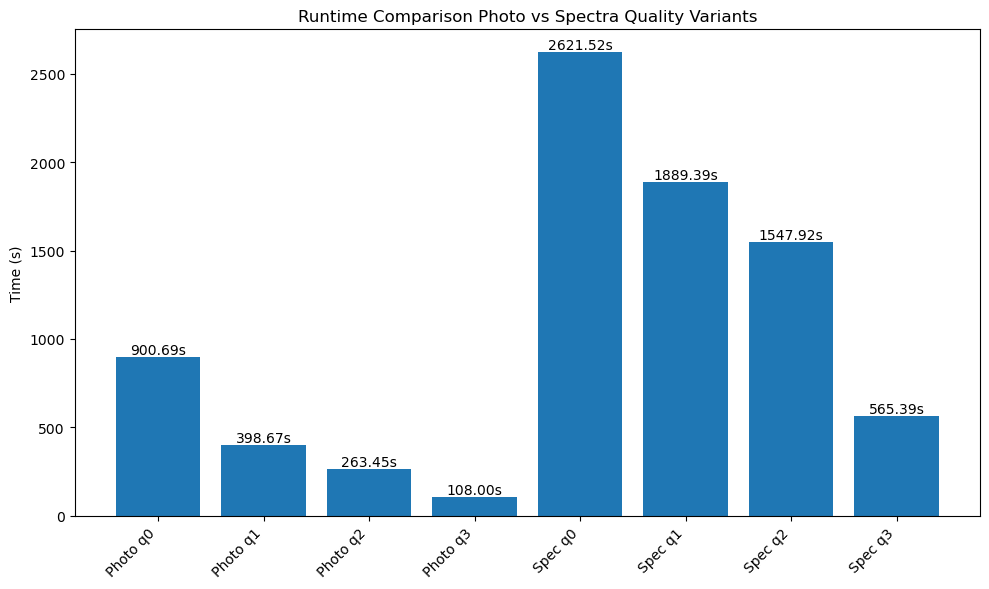

In [17]:
labels = list(runtime.keys())
times = [runtime[l] for l in labels]
plt.figure(figsize=(10,6))
plt.bar(labels, times)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Time (s)')
plt.title('Runtime Comparison Photo vs Spectra Quality Variants')
for i, t in enumerate(times): plt.text(i, t, f"{t:.2f}s", ha='center', va='bottom')
plt.tight_layout()
plt.show()